# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
from sklearn import metrics
from sklearn.model_selection import train_test_split,validation_curve
from hyperopt import hp,Trials,fmin,tpe,STATUS_OK
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor

# Loading Dataset

In [3]:
df = pd.read_csv(r'C:\Programacion\Datasets\cars\Australian Vehicle Prices.csv')

In [31]:
df.head()

,Brand,Year,Model,UsedOrNew,Transmission,DriveType,FuelType,FuelConsumption/100km,Kilometres,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,DEMO,Automatic,AWD,Diesel,8.7,5595.0,NSW,4.0,SUV,4.0,7.0,51990.0
1,MG,2022.0,MG3,USED,Automatic,Front,Premium,6.7,16.0,NSW,4.0,Hatchback,5.0,5.0,19990.0
2,BMW,2022.0,430I,USED,Automatic,Rear,Premium,6.6,8472.0,NSW,4.0,Coupe,2.0,4.0,108988.0
3,Mercedes-Benz,2011.0,E500,USED,Automatic,Rear,Premium,11.0,136517.0,NSW,8.0,Coupe,2.0,4.0,32990.0
4,Renault,2022.0,Arkana,USED,Automatic,Front,Unleaded,6.0,1035.0,NSW,4.0,SUV,4.0,5.0,34990.0


In [5]:
df.drop(columns=['Car/Suv','Title','Engine','ColourExtInt'],inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16626 entries, 0 to 16733
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brand                  16626 non-null  object 
 1   Year                   16626 non-null  float64
 2   Model                  16626 non-null  object 
 3   UsedOrNew              16626 non-null  object 
 4   Transmission           16383 non-null  object 
 5   DriveType              16626 non-null  object 
 6   FuelType               16014 non-null  object 
 7   FuelConsumption/100km  16626 non-null  float64
 8   Kilometres             16626 non-null  float64
 9   Location               16179 non-null  object 
 10  CylindersinEngine      14867 non-null  float64
 11  BodyType               16347 non-null  object 
 12  Doors                  14973 non-null  float64
 13  Seats                  14943 non-null  float64
 14  Price                  16626 non-null  float64
dtypes:

## Cleaning

In [8]:
# Duplicates
df.duplicated().sum()

55

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
# Invalid Values
df.Transmission.replace({'-': np.nan},inplace=True)
df.FuelType.replace({'-': np.nan},inplace=True)
df.FuelConsumption.replace({'-': np.nan},inplace=True)
df.CylindersinEngine.replace({'-': np.nan,'0 L': np.nan, '2 L': np.nan},inplace=True)
df.Kilometres.replace({'-': '0', '- / -': '0'},inplace=True)

In [11]:
df.Price = pd.to_numeric(df.Price,errors='coerce')
df.FuelConsumption = df.FuelConsumption.str.split().str[0].astype('float')
df.rename(columns={'FuelConsumption':'FuelConsumption/100km'},inplace=True)
df.Kilometres = pd.to_numeric(df.Kilometres,errors='coerce')
df.CylindersinEngine = df.CylindersinEngine.str.split().str[0].astype('float')
df.Doors = df.Doors.str.strip()
df.loc[~(df.Doors.isin(['4 Doors','5 Doors','2 Doors','3 Doors'])),'Doors'] = np.nan
df.Doors = df.Doors.str.split().str[0].astype('float')
df.Seats = df.Seats.str.split().str[0].astype('float')
df.loc[df['FuelConsumption/100km']==0,'FuelConsumption/100km'] = np.nan

In [12]:
## dejando solo la locacion de region:
df.Location = df.Location.str.split(',').str[1]

In [13]:
for column in df.select_dtypes('object').columns:
    print(df[column].value_counts(), end='\n\n')

Toyota         2784
Hyundai        1239
Mazda          1176
Holden         1087
Ford           1055
               ... 
Smart             1
Rolls-Royce       1
Polestar          1
Datsun            1
Packard           1
Name: Brand, Length: 76, dtype: int64

Hilux          430
Corolla        405
Ranger         398
Landcruiser    370
I30            366
              ... 
Celerio          1
R-Class          1
Vectra           1
ES300            1
120              1
Name: Model, Length: 781, dtype: int64

USED    14993
NEW      1176
DEMO      509
Name: UsedOrNew, dtype: int64

Automatic    14475
Manual        1952
Name: Transmission, dtype: int64

Front    6936
4WD      3135
AWD      3113
Rear     2349
Other    1145
Name: DriveType, dtype: int64

Unleaded    6976
Diesel      4898
Premium     3363
Hybrid       649
Electric     114
Other         41
LPG           15
Leaded         5
Name: FuelType, dtype: int64

 NSW       6376
 VIC       3861
 QLD       2729
 WA        1789
 SA         800


In [43]:
# Missing Values
df.isna().sum()

Brand                       0
Year                        0
Model                       0
UsedOrNew                   0
Transmission              243
DriveType                   0
FuelType                  612
FuelConsumption/100km       0
Kilometres                  0
Location                  447
CylindersinEngine        1759
BodyType                  279
Doors                    1653
Seats                    1683
Price                       0
dtype: int64

In [15]:
df.dropna(subset='Price',inplace=True)
df.fillna({'FuelConsumption/100km': df['FuelConsumption/100km'].mean(),
          'Kilometres': df.Kilometres.median()},inplace=True)

# EDA

In [16]:
sns.set_style('darkgrid')

In [17]:
df.Price.mean(), df.Price.median()

(37265.316492241065, 29489.0)

In [18]:
df.Year.min(), df.Year.max()

(1940.0, 2023.0)

Text(0.5, 0.98, 'Densidad de la cantidad de carros a traves de los años')

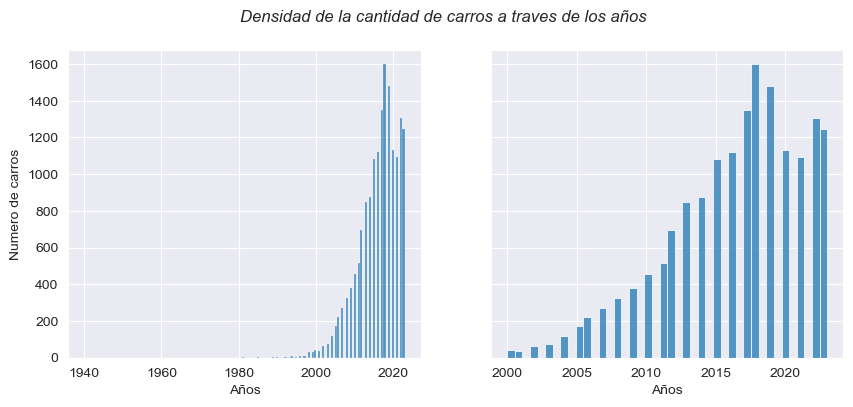

In [19]:
fig0,ax0 = plt.subplots(1,2,figsize=(10,4),sharey=True)
sns.histplot(df.Year,ax=ax0[0])
ax0[0].set_ylabel('Numero de carros')
ax0[0].set_xlabel('Años')
sns.histplot(df.loc[df.Year>=2000,'Year'],ax=ax0[1])
ax0[1].set_xlabel('Años')
fig0.suptitle('Densidad de la cantidad de carros a traves de los años',style='italic')

<Axes: title={'center': 'Medaina de precio a traves de los años'}, xlabel='Year'>

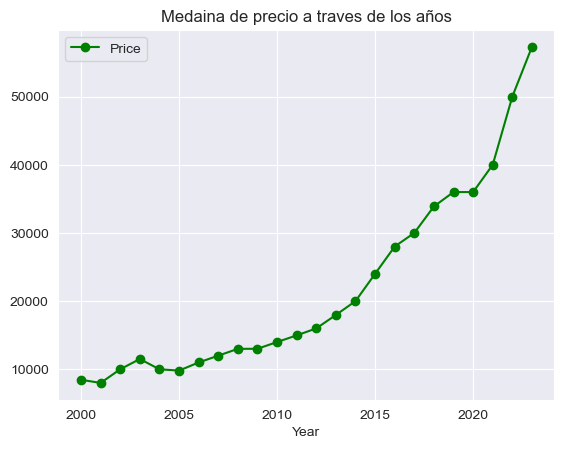

In [28]:
df.loc[df.Year>=2000].groupby('Year')['Price'].median().reset_index().plot(x='Year',y='Price',marker='o',color='g',title='Medaina de precio a traves de los años')

Text(0.5, 0.98, 'Marcas con mas carros')

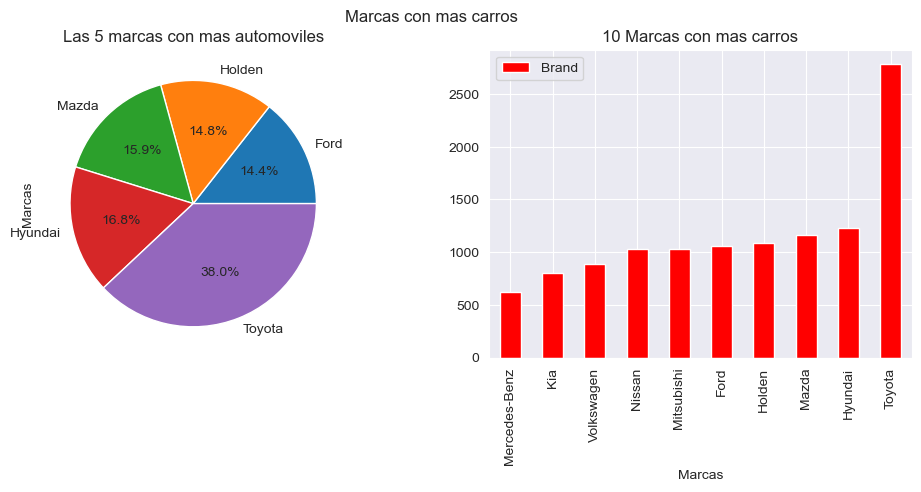

In [21]:
fig1, ax1 = plt.subplots(1,2,figsize=(12,4))
df.Brand.value_counts().sort_values().tail(10).reset_index().plot(kind='bar',x='index',y='Brand',xlabel='Marcas',color='r',ax=ax1[1],)
ax1[1].set_title('10 Marcas con mas carros')
df.Brand.value_counts().sort_values().tail(5).plot(kind='pie',label='Marcas',ax=ax1[0],autopct='%1.1f%%')
ax1[0].set_title('Las 5 marcas con mas automoviles')
fig1.suptitle('Marcas con mas carros')


<Axes: title={'center': 'Mediana de precio segun transimision'}, xlabel='Transmission'>

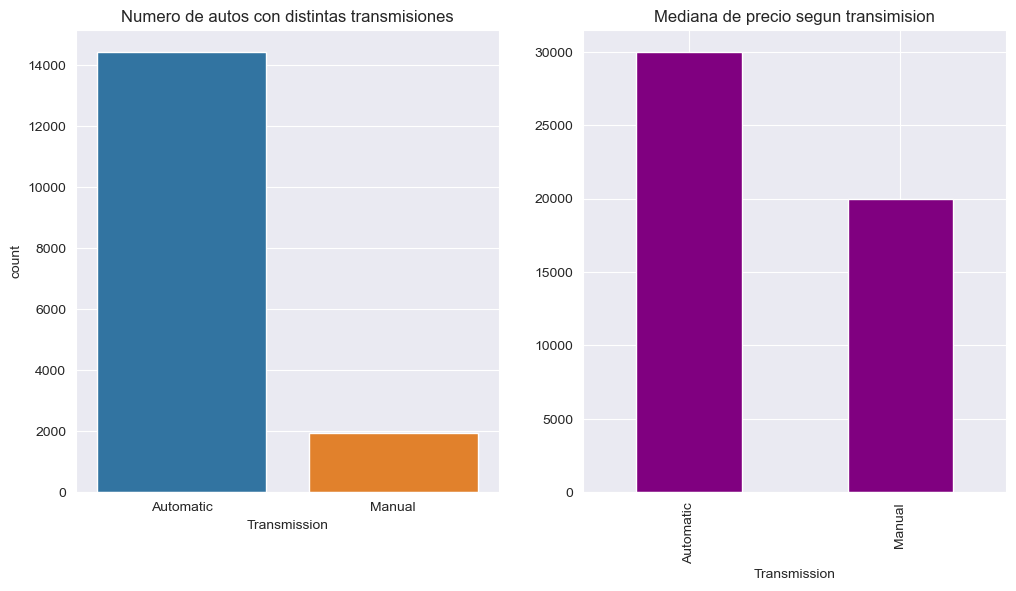

In [22]:
fig2,ax2 = plt.subplots(1,2,figsize=(12,6))
sns.countplot(x=df.Transmission,ax=ax2[0])
ax2[0].set_title('Numero de autos con distintas transmisiones')
df.groupby('Transmission')['Price'].median().plot(kind='bar',color='purple',ax=ax2[1],title='Mediana de precio segun transimision')

Text(0.5, 0, 'Kilomeraje')

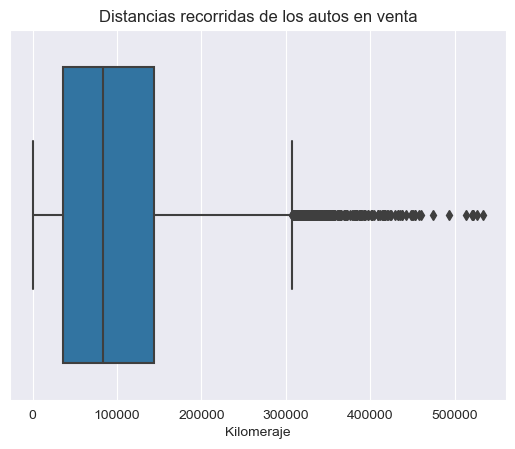

In [23]:
sns.boxplot(x=df.Kilometres)
plt.title('Distancias recorridas de los autos en venta')
plt.xlabel('Kilomeraje')

Text(0.5, 1.0, 'Hexbin')

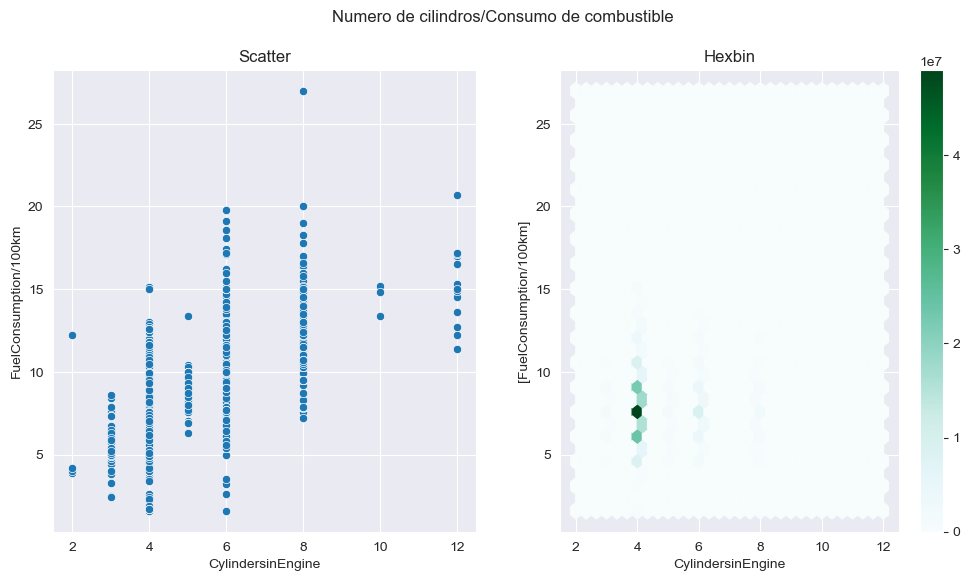

In [41]:
fig3, ax3 = plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(x=df.CylindersinEngine,y=df['FuelConsumption/100km'],ax=ax3[0])
df.plot.hexbin(x='CylindersinEngine',y=['FuelConsumption/100km'],gridsize=30,ax=ax3[1])
fig3.suptitle('Numero de cilindros/Consumo de combustible')
ax3[0].set_title('Scatter')
ax3[1].set_title('Hexbin')

<Axes: title={'center': 'Mediana de precios segun estado'}, xlabel='Locacion'>

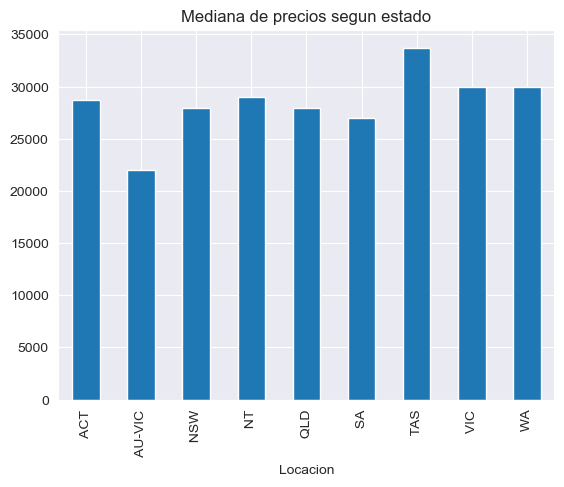

In [25]:
df.groupby('Location')['Price'].median().plot.bar(title='Mediana de precios segun estado',xlabel='Locacion',y='Mediana')

In [26]:
np.std(df.CylindersinEngine)

1.062021925104604

In [27]:
np.std(df.Price)

37031.0063216109

In [149]:
np.var(df.Price)

1371295429.1911862

### Without Outliers

<Axes: xlabel='Price'>

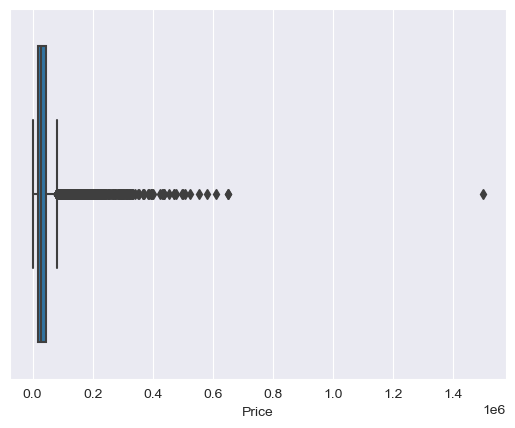

In [163]:
sns.boxplot(x=df.Price)

In [164]:
dfc = df.copy()
iqr = dfc.Price.quantile(0.75) - dfc.Price.quantile(0.25)
lower_bound = df.Price.quantile(0.25) - (1.5*iqr)
upper_bound = df.Price.quantile(0.75) + (1.5*iqr)
dfc.drop(dfc.loc[(dfc.Price<=lower_bound) | (dfc.Price>=upper_bound)].index,inplace=True)

<Axes: xlabel='Price'>

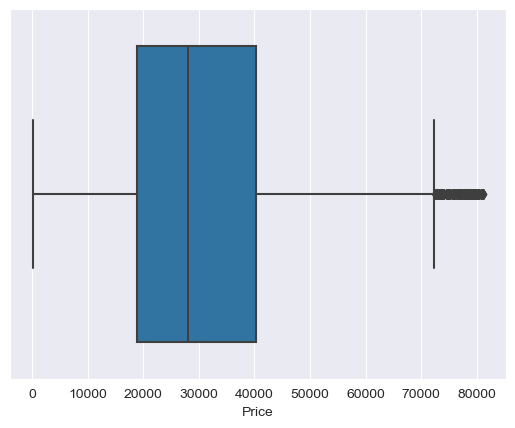

In [165]:
sns.boxplot(x=dfc.Price)

In [166]:
df = dfc.copy()

# Fueature Engineering

In [45]:
df.select_dtypes(['int','float']).corr()

,Year,FuelConsumption/100km,Kilometres,CylindersinEngine,Doors,Seats,Price
Year,1.000000,-0.324482,-0.722207,-0.203699,0.071805,0.013281,0.354584
FuelConsumption/100km,-0.324482,1.000000,0.292010,0.636449,-0.312414,0.043468,0.129895
Kilometres,-0.722207,0.292010,1.000000,0.137666,-0.087569,0.020472,-0.398221
CylindersinEngine,-0.203699,0.636449,0.137666,1.000000,-0.239755,0.012892,0.390987
Doors,0.071805,-0.312414,-0.087569,-0.239755,1.000000,0.371459,-0.196190
Seats,0.013281,0.043468,0.020472,0.012892,0.371459,1.000000,-0.043381
Price,0.354584,0.129895,-0.398221,0.390987,-0.196190,-0.043381,1.000000


In [167]:
X = df.drop(['Price'],axis=1)
numerical_features = X.select_dtypes(['int','float']).columns.tolist()
categorical_features = X.select_dtypes('object').columns.tolist()
imputer = SimpleImputer(strategy='most_frequent')
catp = Pipeline(steps=(['imp',imputer],['cat',OneHotEncoder()]))
colt = ColumnTransformer(transformers=(['num',imputer,numerical_features],
                                      ['cat',catp,categorical_features]))

In [168]:
X = colt.fit_transform(X).toarray()
y = df.Price
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [169]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [170]:
X.shape

(15698, 779)

# ML

## LinearSVR

In [175]:
rango = range(15,20)
X_score,y_score = validation_curve(LinearSVR(dual=True),X_train_std,y_train,param_range=rango,param_name='C',scoring='neg_mean_squared_error')
X_score,y_score = [-(np.mean(x)) for x in X_score], [-(np.mean(y)) for y in y_score]

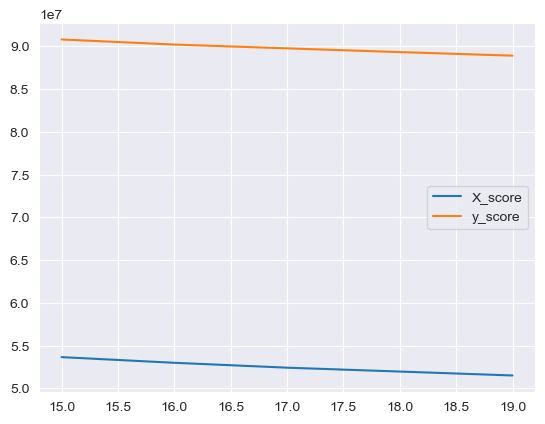

In [176]:
plt.plot(rango,X_score,label='X_score')
plt.plot(rango,y_score,label='y_score')
plt.legend()

### With Outliers

In [134]:
svr = LinearSVR(C=28,dual=True)
svr.fit(X_train_std,y_train)
y_pred = svr.predict(X_test_std)

In [135]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
print(f'{mean_squared_error(y_test,y_pred)},{mean_absolute_error(y_test,y_pred)}')

881620424.7947702,7623.22904696465


### Without Outliers

In [184]:
svr = LinearSVR(C=19,dual=True)
svr.fit(X_train_std,y_train)
y_pred = svr.predict(X_test_std)

In [185]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
print(f'{mean_squared_error(y_test,y_pred)},{mean_absolute_error(y_test,y_pred)}')

62040387.17556003,4936.310407881619


## XGBR

In [179]:
space = {'n_estimators': hp.quniform('n_estimators',50,150,1),'max_depth':hp.quniform('max_depth',5,20,1),'learning_rate': hp.uniform('learning_rate',0.001,0.1),'subsample': hp.uniform('subsample',0,1)}
def objective(space):
    model = XGBRegressor(n_estimators=int(space['n_estimators']),max_depth= int(space['max_depth']),learning_rate = space['learning_rate'],subsample=space['subsample'])
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    model.fit(X_train, y_train,eval_set=evaluation)
    pred = model.predict(X_test)
    mean_squared_error = metrics.mean_squared_error(y_test, pred)
    return {'loss': mean_squared_error, 'status': STATUS_OK }
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

[0]	validation_0-rmse:16002.89998	validation_1-rmse:15666.79173
[1]	validation_0-rmse:15363.62068	validation_1-rmse:15032.64413
[2]	validation_0-rmse:14759.70529	validation_1-rmse:14433.94975
[3]	validation_0-rmse:14227.15038	validation_1-rmse:13906.65874
[4]	validation_0-rmse:13716.73126	validation_1-rmse:13404.51259
[5]	validation_0-rmse:13242.49717	validation_1-rmse:12944.50871
[6]	validation_0-rmse:12814.53683	validation_1-rmse:12512.15339
[7]	validation_0-rmse:12418.40635	validation_1-rmse:12129.67358
[8]	validation_0-rmse:12039.10004	validation_1-rmse:11752.35677
[9]	validation_0-rmse:11680.23479	validation_1-rmse:11420.40295
[10]	validation_0-rmse:11343.25731	validation_1-rmse:11090.21689
[11]	validation_0-rmse:11046.02493	validation_1-rmse:10797.49099
[12]	validation_0-rmse:10726.10907	validation_1-rmse:10487.16568
[13]	validation_0-rmse:10460.18407	validation_1-rmse:10238.30396
[14]	validation_0-rmse:10202.75209	validation_1-rmse:9982.41039
[15]	validation_0-rmse:9974.73541	va

[40]	validation_0-rmse:5670.84790	validation_1-rmse:6379.07836                  
[41]	validation_0-rmse:5632.11215	validation_1-rmse:6353.75094                  
[42]	validation_0-rmse:5596.55611	validation_1-rmse:6333.97055                  
[43]	validation_0-rmse:5570.81236	validation_1-rmse:6320.34385                  
[44]	validation_0-rmse:5533.23329	validation_1-rmse:6290.76192                  
[45]	validation_0-rmse:5500.56287	validation_1-rmse:6267.33508                  
[46]	validation_0-rmse:5469.33108	validation_1-rmse:6251.46638                  
[47]	validation_0-rmse:5449.33531	validation_1-rmse:6230.57082                  
[48]	validation_0-rmse:5428.63320	validation_1-rmse:6219.26071                  
[49]	validation_0-rmse:5406.91978	validation_1-rmse:6209.71541                  
[50]	validation_0-rmse:5386.03479	validation_1-rmse:6197.69926                  
[51]	validation_0-rmse:5372.05305	validation_1-rmse:6188.76319                  
[52]	validation_0-rmse:5359.

[9]	validation_0-rmse:11561.01830	validation_1-rmse:11685.88108                  
[10]	validation_0-rmse:11168.02345	validation_1-rmse:11341.54950                 
[11]	validation_0-rmse:10791.15342	validation_1-rmse:11013.42164                 
[12]	validation_0-rmse:10431.57997	validation_1-rmse:10711.45302                 
[13]	validation_0-rmse:10087.78733	validation_1-rmse:10418.59619                 
[14]	validation_0-rmse:9761.04620	validation_1-rmse:10142.84667                  
[15]	validation_0-rmse:9442.43590	validation_1-rmse:9874.81522                   
[16]	validation_0-rmse:9143.12054	validation_1-rmse:9622.48370                   
[17]	validation_0-rmse:8854.28602	validation_1-rmse:9390.89421                   
[18]	validation_0-rmse:8580.64648	validation_1-rmse:9166.93630                   
[19]	validation_0-rmse:8313.70980	validation_1-rmse:8952.90404                   
[20]	validation_0-rmse:8063.59646	validation_1-rmse:8756.88054                   
[21]	validation_

[108]	validation_0-rmse:2425.40967	validation_1-rmse:5563.10352                  
[109]	validation_0-rmse:2419.32653	validation_1-rmse:5560.69311                  
[110]	validation_0-rmse:2410.52555	validation_1-rmse:5557.03788                  
[111]	validation_0-rmse:2403.59513	validation_1-rmse:5554.08452                  
[112]	validation_0-rmse:2395.88689	validation_1-rmse:5550.99882                  
[113]	validation_0-rmse:2389.58158	validation_1-rmse:5548.51460                  
[114]	validation_0-rmse:2385.62707	validation_1-rmse:5546.95110                  
[115]	validation_0-rmse:2380.60093	validation_1-rmse:5545.20311                  
[116]	validation_0-rmse:2373.32096	validation_1-rmse:5544.38229                  
[117]	validation_0-rmse:2366.00127	validation_1-rmse:5541.57679                  
[118]	validation_0-rmse:2357.90322	validation_1-rmse:5539.58160                  
[119]	validation_0-rmse:2348.99109	validation_1-rmse:5536.55990                  
[120]	validation

[62]	validation_0-rmse:6896.95303	validation_1-rmse:7217.57083                   
[63]	validation_0-rmse:6857.46220	validation_1-rmse:7186.14004                   
[64]	validation_0-rmse:6819.33284	validation_1-rmse:7155.24127                   
[65]	validation_0-rmse:6785.21831	validation_1-rmse:7130.90294                   
[66]	validation_0-rmse:6749.34567	validation_1-rmse:7101.79833                   
[67]	validation_0-rmse:6711.54556	validation_1-rmse:7069.64025                   
[68]	validation_0-rmse:6669.87917	validation_1-rmse:7037.66631                   
[69]	validation_0-rmse:6635.71167	validation_1-rmse:7008.32960                   
[70]	validation_0-rmse:6602.56091	validation_1-rmse:6984.47991                   
[71]	validation_0-rmse:6569.76734	validation_1-rmse:6957.94123                   
[72]	validation_0-rmse:6535.06615	validation_1-rmse:6929.69094                   
[73]	validation_0-rmse:6503.60573	validation_1-rmse:6906.56201                   
[74]	validation_

[76]	validation_0-rmse:1972.96134	validation_1-rmse:5412.88043                   
[77]	validation_0-rmse:1966.45628	validation_1-rmse:5412.23271                   
[78]	validation_0-rmse:1961.84619	validation_1-rmse:5409.87715                   
[79]	validation_0-rmse:1953.30615	validation_1-rmse:5407.32060                   
[80]	validation_0-rmse:1945.03482	validation_1-rmse:5407.11898                   
[81]	validation_0-rmse:1935.82158	validation_1-rmse:5404.80474                   
[82]	validation_0-rmse:1926.87118	validation_1-rmse:5400.32840                   
[83]	validation_0-rmse:1922.03189	validation_1-rmse:5397.45936                   
[84]	validation_0-rmse:1912.22554	validation_1-rmse:5394.70112                   
[85]	validation_0-rmse:1902.35579	validation_1-rmse:5391.39920                   
[86]	validation_0-rmse:1896.02206	validation_1-rmse:5388.25849                   
[87]	validation_0-rmse:1889.01623	validation_1-rmse:5387.64725                   
[88]	validation_

[67]	validation_0-rmse:11348.76956	validation_1-rmse:11320.16970                 
[68]	validation_0-rmse:11291.15217	validation_1-rmse:11268.08123                 
[69]	validation_0-rmse:11234.21235	validation_1-rmse:11216.34259                 
[70]	validation_0-rmse:11176.99460	validation_1-rmse:11163.93532                 
[71]	validation_0-rmse:11120.89137	validation_1-rmse:11112.63316                 
[72]	validation_0-rmse:11064.40216	validation_1-rmse:11061.55768                 
[73]	validation_0-rmse:11008.93281	validation_1-rmse:11011.56256                 
[74]	validation_0-rmse:10953.90209	validation_1-rmse:10961.44719                 
[75]	validation_0-rmse:10899.28966	validation_1-rmse:10911.02960                 
[76]	validation_0-rmse:10845.29869	validation_1-rmse:10862.71161                 
[77]	validation_0-rmse:10790.79030	validation_1-rmse:10812.30403                 
[78]	validation_0-rmse:10736.69782	validation_1-rmse:10764.05012                 
[79]	validation_

[47]	validation_0-rmse:7025.84590	validation_1-rmse:7352.19637                   
[48]	validation_0-rmse:6955.28699	validation_1-rmse:7293.69710                   
[49]	validation_0-rmse:6894.05683	validation_1-rmse:7242.82106                   
[50]	validation_0-rmse:6831.53505	validation_1-rmse:7195.41378                   
[51]	validation_0-rmse:6771.69937	validation_1-rmse:7147.43849                   
[52]	validation_0-rmse:6718.68210	validation_1-rmse:7104.28389                   
[53]	validation_0-rmse:6661.82904	validation_1-rmse:7058.69511                   
[54]	validation_0-rmse:6611.89402	validation_1-rmse:7020.28638                   
[55]	validation_0-rmse:6560.63136	validation_1-rmse:6982.82769                   
[56]	validation_0-rmse:6515.67273	validation_1-rmse:6949.44847                   
[57]	validation_0-rmse:6471.93597	validation_1-rmse:6915.17804                   
[58]	validation_0-rmse:6426.70777	validation_1-rmse:6879.86954                   
[59]	validation_

[52]	validation_0-rmse:5043.56668	validation_1-rmse:6150.64218                   
[53]	validation_0-rmse:4992.46986	validation_1-rmse:6120.16720                   
[54]	validation_0-rmse:4945.57019	validation_1-rmse:6085.33655                   
[55]	validation_0-rmse:4892.49467	validation_1-rmse:6052.10672                   
[56]	validation_0-rmse:4855.38727	validation_1-rmse:6033.01879                   
[57]	validation_0-rmse:4811.23343	validation_1-rmse:6008.00043                   
[58]	validation_0-rmse:4769.00249	validation_1-rmse:5980.55184                   
[0]	validation_0-rmse:16520.46699	validation_1-rmse:16196.89726                  
[1]	validation_0-rmse:16415.35704	validation_1-rmse:16092.60770                  
[2]	validation_0-rmse:16312.68871	validation_1-rmse:15992.99233                  
[3]	validation_0-rmse:16210.84967	validation_1-rmse:15892.79908                  
[4]	validation_0-rmse:16110.33437	validation_1-rmse:15795.02117                  
[5]	validation_0

[92]	validation_0-rmse:10111.92944	validation_1-rmse:10010.70246                 
[93]	validation_0-rmse:10070.93941	validation_1-rmse:9973.18680                  
[94]	validation_0-rmse:10030.34777	validation_1-rmse:9936.11387                  
[95]	validation_0-rmse:9988.32064	validation_1-rmse:9897.77897                   
[96]	validation_0-rmse:9947.21524	validation_1-rmse:9860.34802                   
[97]	validation_0-rmse:9908.55292	validation_1-rmse:9823.75769                   
[98]	validation_0-rmse:9868.00743	validation_1-rmse:9785.46401                   
[99]	validation_0-rmse:9828.41222	validation_1-rmse:9746.47731                   
[100]	validation_0-rmse:9788.96487	validation_1-rmse:9709.16139                  
[101]	validation_0-rmse:9750.69159	validation_1-rmse:9673.48341                  
[102]	validation_0-rmse:9706.71255	validation_1-rmse:9632.27613                  
[103]	validation_0-rmse:9668.42548	validation_1-rmse:9598.80402                  
[104]	validation

[65]	validation_0-rmse:3698.85303	validation_1-rmse:5612.69478                    
[66]	validation_0-rmse:3670.80231	validation_1-rmse:5599.57842                    
[67]	validation_0-rmse:3649.61679	validation_1-rmse:5590.70471                    
[68]	validation_0-rmse:3629.90411	validation_1-rmse:5581.23948                    
[69]	validation_0-rmse:3598.72036	validation_1-rmse:5569.77959                    
[70]	validation_0-rmse:3574.74669	validation_1-rmse:5557.90735                    
[71]	validation_0-rmse:3553.81763	validation_1-rmse:5547.49368                    
[72]	validation_0-rmse:3527.76041	validation_1-rmse:5533.87435                    
[73]	validation_0-rmse:3507.57147	validation_1-rmse:5528.29481                    
[74]	validation_0-rmse:3484.35346	validation_1-rmse:5514.45392                    
[75]	validation_0-rmse:3463.16988	validation_1-rmse:5503.98099                    
[76]	validation_0-rmse:3445.48782	validation_1-rmse:5498.51256                    
[77]

[24]	validation_0-rmse:4687.64704	validation_1-rmse:6628.30472                   
[25]	validation_0-rmse:4510.87923	validation_1-rmse:6538.84683                   
[26]	validation_0-rmse:4338.87850	validation_1-rmse:6454.82977                   
[27]	validation_0-rmse:4176.47023	validation_1-rmse:6379.95141                   
[28]	validation_0-rmse:4031.58980	validation_1-rmse:6314.52373                   
[29]	validation_0-rmse:3896.50176	validation_1-rmse:6252.50050                   
[30]	validation_0-rmse:3767.01864	validation_1-rmse:6194.08994                   
[31]	validation_0-rmse:3651.81265	validation_1-rmse:6150.69218                   
[32]	validation_0-rmse:3538.81938	validation_1-rmse:6102.15205                   
[33]	validation_0-rmse:3435.07247	validation_1-rmse:6065.00079                   
[34]	validation_0-rmse:3332.09009	validation_1-rmse:6028.55886                   
[35]	validation_0-rmse:3245.25518	validation_1-rmse:5998.06344                   
[36]	validation_

[123]	validation_0-rmse:1603.61148	validation_1-rmse:5550.69000                  
[124]	validation_0-rmse:1602.63579	validation_1-rmse:5549.42620                  
[125]	validation_0-rmse:1601.62996	validation_1-rmse:5548.76569                  
[126]	validation_0-rmse:1597.45585	validation_1-rmse:5548.96824                  
[127]	validation_0-rmse:1588.11185	validation_1-rmse:5545.52976                  
[128]	validation_0-rmse:1587.17592	validation_1-rmse:5545.38084                  
[129]	validation_0-rmse:1584.47948	validation_1-rmse:5545.43902                  
[130]	validation_0-rmse:1580.87110	validation_1-rmse:5544.41212                  
[131]	validation_0-rmse:1580.01941	validation_1-rmse:5544.05785                  
[132]	validation_0-rmse:1573.69892	validation_1-rmse:5543.27684                  
[133]	validation_0-rmse:1568.93030	validation_1-rmse:5543.23701                  
[134]	validation_0-rmse:1563.64555	validation_1-rmse:5542.38944                  
[135]	validation

[76]	validation_0-rmse:6460.29748	validation_1-rmse:6789.16128                   
[77]	validation_0-rmse:6447.70018	validation_1-rmse:6777.47603                   
[78]	validation_0-rmse:6432.57077	validation_1-rmse:6769.51138                   
[79]	validation_0-rmse:6424.60301	validation_1-rmse:6763.88068                   
[80]	validation_0-rmse:6411.04000	validation_1-rmse:6750.47166                   
[81]	validation_0-rmse:6401.20213	validation_1-rmse:6742.41668                   
[82]	validation_0-rmse:6391.64462	validation_1-rmse:6734.36579                   
[83]	validation_0-rmse:6373.45651	validation_1-rmse:6723.18078                   
[84]	validation_0-rmse:6366.08820	validation_1-rmse:6718.87435                   
[85]	validation_0-rmse:6356.50174	validation_1-rmse:6713.06692                   
[86]	validation_0-rmse:6346.56339	validation_1-rmse:6707.61771                   
[87]	validation_0-rmse:6336.31438	validation_1-rmse:6701.18712                   
[88]	validation_

[77]	validation_0-rmse:7257.31345	validation_1-rmse:7459.10141                   
[78]	validation_0-rmse:7211.09455	validation_1-rmse:7418.45976                   
[79]	validation_0-rmse:7172.61243	validation_1-rmse:7389.02723                   
[80]	validation_0-rmse:7128.89764	validation_1-rmse:7351.81568                   
[81]	validation_0-rmse:7090.61980	validation_1-rmse:7318.53294                   
[82]	validation_0-rmse:7048.45554	validation_1-rmse:7278.97762                   
[83]	validation_0-rmse:7012.20603	validation_1-rmse:7244.41426                   
[84]	validation_0-rmse:6977.75824	validation_1-rmse:7213.36814                   
[85]	validation_0-rmse:6949.26559	validation_1-rmse:7190.24044                   
[86]	validation_0-rmse:6917.32649	validation_1-rmse:7161.73714                   
[87]	validation_0-rmse:6884.45517	validation_1-rmse:7132.26766                   
[88]	validation_0-rmse:6857.27820	validation_1-rmse:7110.24905                   
[89]	validation_

[67]	validation_0-rmse:8631.16578	validation_1-rmse:8562.29280                   
[68]	validation_0-rmse:8587.07747	validation_1-rmse:8523.47089                   
[69]	validation_0-rmse:8539.66639	validation_1-rmse:8480.22513                   
[70]	validation_0-rmse:8495.62540	validation_1-rmse:8443.19402                   
[71]	validation_0-rmse:8453.02030	validation_1-rmse:8406.14069                   
[72]	validation_0-rmse:8407.78842	validation_1-rmse:8365.10699                   
[73]	validation_0-rmse:8362.89985	validation_1-rmse:8322.60566                   
[74]	validation_0-rmse:8322.20263	validation_1-rmse:8286.40755                   
[75]	validation_0-rmse:8287.86195	validation_1-rmse:8257.51212                   
[0]	validation_0-rmse:15863.18871	validation_1-rmse:15584.33465                  
[1]	validation_0-rmse:15147.15573	validation_1-rmse:14909.43949                  
[2]	validation_0-rmse:14471.49445	validation_1-rmse:14281.35900                  
[3]	validation_0

[17]	validation_0-rmse:10922.21453	validation_1-rmse:10954.09220                 
[18]	validation_0-rmse:10693.07834	validation_1-rmse:10744.72129                 
[19]	validation_0-rmse:10470.20226	validation_1-rmse:10546.60951                 
[20]	validation_0-rmse:10258.53310	validation_1-rmse:10356.36524                 
[21]	validation_0-rmse:10055.06404	validation_1-rmse:10176.34517                 
[22]	validation_0-rmse:9854.36265	validation_1-rmse:9998.62797                   
[23]	validation_0-rmse:9661.90107	validation_1-rmse:9833.29938                   
[24]	validation_0-rmse:9472.75160	validation_1-rmse:9669.48517                   
[25]	validation_0-rmse:9289.73359	validation_1-rmse:9509.44629                   
[26]	validation_0-rmse:9114.20601	validation_1-rmse:9357.58470                   
[27]	validation_0-rmse:8943.47899	validation_1-rmse:9207.94541                   
[28]	validation_0-rmse:8776.12194	validation_1-rmse:9064.48352                   
[29]	validation_

[3]	validation_0-rmse:15283.74944	validation_1-rmse:15012.85174                  
[4]	validation_0-rmse:14970.33802	validation_1-rmse:14721.76403                  
[5]	validation_0-rmse:14658.63612	validation_1-rmse:14424.00365                  
[6]	validation_0-rmse:14362.79333	validation_1-rmse:14147.32400                  
[7]	validation_0-rmse:14072.45776	validation_1-rmse:13871.09626                  
[8]	validation_0-rmse:13790.95082	validation_1-rmse:13604.78088                  
[9]	validation_0-rmse:13517.63932	validation_1-rmse:13343.31760                  
[10]	validation_0-rmse:13251.56787	validation_1-rmse:13094.99215                 
[11]	validation_0-rmse:12993.34886	validation_1-rmse:12857.49865                 
[12]	validation_0-rmse:12738.75831	validation_1-rmse:12619.83289                 
[13]	validation_0-rmse:12488.60726	validation_1-rmse:12385.10386                 
[14]	validation_0-rmse:12246.67555	validation_1-rmse:12157.89195                 
[15]	validation_

[102]	validation_0-rmse:4174.64140	validation_1-rmse:5746.35050                  
[103]	validation_0-rmse:4151.29726	validation_1-rmse:5737.09700                  
[104]	validation_0-rmse:4127.50146	validation_1-rmse:5724.74854                  
[105]	validation_0-rmse:4107.53324	validation_1-rmse:5713.96457                  
[106]	validation_0-rmse:4084.83246	validation_1-rmse:5703.74228                  
[107]	validation_0-rmse:4060.64838	validation_1-rmse:5695.69096                  
[0]	validation_0-rmse:15897.69624	validation_1-rmse:15612.66509                  
[1]	validation_0-rmse:15207.90166	validation_1-rmse:14959.50958                  
[2]	validation_0-rmse:14563.67135	validation_1-rmse:14348.43816                  
[3]	validation_0-rmse:13954.22799	validation_1-rmse:13768.75123                  
[4]	validation_0-rmse:13373.09122	validation_1-rmse:13221.78043                  
[5]	validation_0-rmse:12832.71717	validation_1-rmse:12723.24982                  
[6]	validation_0

[1]	validation_0-rmse:16508.65655	validation_1-rmse:16190.14246                  
[2]	validation_0-rmse:16450.55832	validation_1-rmse:16136.11426                  
[3]	validation_0-rmse:16392.61582	validation_1-rmse:16082.73543                  
[4]	validation_0-rmse:16335.13231	validation_1-rmse:16029.36760                  
[5]	validation_0-rmse:16277.46323	validation_1-rmse:15975.99986                  
[6]	validation_0-rmse:16220.18642	validation_1-rmse:15923.04005                  
[7]	validation_0-rmse:16163.19866	validation_1-rmse:15869.73228                  
[8]	validation_0-rmse:16106.76718	validation_1-rmse:15817.18573                  
[9]	validation_0-rmse:16050.42270	validation_1-rmse:15764.83976                  
[10]	validation_0-rmse:15993.96486	validation_1-rmse:15712.32401                 
[11]	validation_0-rmse:15937.95138	validation_1-rmse:15659.94429                 
[12]	validation_0-rmse:15881.87058	validation_1-rmse:15608.16245                 
[13]	validation_

[6]	validation_0-rmse:10470.64784	validation_1-rmse:10679.70663                  
[7]	validation_0-rmse:9840.78893	validation_1-rmse:10146.69569                   
[8]	validation_0-rmse:9258.68950	validation_1-rmse:9651.16622                    
[9]	validation_0-rmse:8729.22704	validation_1-rmse:9210.57854                    
[10]	validation_0-rmse:8241.04971	validation_1-rmse:8819.39112                   
[11]	validation_0-rmse:7789.25131	validation_1-rmse:8464.68261                   
[12]	validation_0-rmse:7371.57622	validation_1-rmse:8155.04155                   
[13]	validation_0-rmse:6984.12620	validation_1-rmse:7866.81491                   
[14]	validation_0-rmse:6624.20843	validation_1-rmse:7603.47523                   
[15]	validation_0-rmse:6293.70130	validation_1-rmse:7371.46378                   
[16]	validation_0-rmse:5993.24433	validation_1-rmse:7164.91599                   
[17]	validation_0-rmse:5715.56335	validation_1-rmse:6981.49067                   
[18]	validation_

[105]	validation_0-rmse:1853.23470	validation_1-rmse:5307.59815                  
[106]	validation_0-rmse:1850.38497	validation_1-rmse:5308.90649                  
[107]	validation_0-rmse:1843.95767	validation_1-rmse:5304.13724                  
[108]	validation_0-rmse:1841.97192	validation_1-rmse:5304.87923                  
[109]	validation_0-rmse:1836.43943	validation_1-rmse:5303.48143                  
[110]	validation_0-rmse:1831.44620	validation_1-rmse:5301.54313                  
[111]	validation_0-rmse:1830.03422	validation_1-rmse:5299.98996                  
[112]	validation_0-rmse:1822.75051	validation_1-rmse:5298.67066                  
[113]	validation_0-rmse:1817.10690	validation_1-rmse:5296.64038                  
[114]	validation_0-rmse:1814.15279	validation_1-rmse:5293.97161                  
[115]	validation_0-rmse:1806.83092	validation_1-rmse:5293.25269                  
[116]	validation_0-rmse:1801.46390	validation_1-rmse:5291.84668                  
[117]	validation

[70]	validation_0-rmse:2000.21433	validation_1-rmse:5422.19622                   
[71]	validation_0-rmse:1991.43279	validation_1-rmse:5419.11550                   
[72]	validation_0-rmse:1976.17918	validation_1-rmse:5416.75896                   
[73]	validation_0-rmse:1958.09445	validation_1-rmse:5412.99834                   
[74]	validation_0-rmse:1945.43406	validation_1-rmse:5410.00427                   
[75]	validation_0-rmse:1929.96544	validation_1-rmse:5406.05754                   
[76]	validation_0-rmse:1916.54087	validation_1-rmse:5404.41425                   
[77]	validation_0-rmse:1903.44618	validation_1-rmse:5401.48138                   
[78]	validation_0-rmse:1895.90755	validation_1-rmse:5400.73672                   
[79]	validation_0-rmse:1886.90984	validation_1-rmse:5398.94327                   
[80]	validation_0-rmse:1876.66600	validation_1-rmse:5396.66618                   
[81]	validation_0-rmse:1872.12737	validation_1-rmse:5395.80826                   
[82]	validation_

[35]	validation_0-rmse:3174.70634	validation_1-rmse:5681.47408                   
[36]	validation_0-rmse:3095.04828	validation_1-rmse:5653.60434                   
[37]	validation_0-rmse:3029.85092	validation_1-rmse:5633.86908                   
[38]	validation_0-rmse:2965.49214	validation_1-rmse:5612.62706                   
[39]	validation_0-rmse:2901.74471	validation_1-rmse:5593.91427                   
[40]	validation_0-rmse:2839.90411	validation_1-rmse:5580.39895                   
[41]	validation_0-rmse:2784.24121	validation_1-rmse:5562.78082                   
[42]	validation_0-rmse:2742.33913	validation_1-rmse:5551.16178                   
[43]	validation_0-rmse:2692.41490	validation_1-rmse:5538.69675                   
[44]	validation_0-rmse:2638.58687	validation_1-rmse:5512.24442                   
[45]	validation_0-rmse:2600.41910	validation_1-rmse:5500.15939                   
[46]	validation_0-rmse:2561.59122	validation_1-rmse:5490.92593                   
[47]	validation_

[134]	validation_0-rmse:1652.42280	validation_1-rmse:5266.19344                  
[135]	validation_0-rmse:1649.80377	validation_1-rmse:5265.62432                  
[0]	validation_0-rmse:15384.30124	validation_1-rmse:15142.21793                   
[1]	validation_0-rmse:14270.99590	validation_1-rmse:14092.31588                   
[2]	validation_0-rmse:13256.55001	validation_1-rmse:13139.00733                   
[3]	validation_0-rmse:12335.81173	validation_1-rmse:12294.90120                   
[4]	validation_0-rmse:11502.39618	validation_1-rmse:11548.86574                   
[5]	validation_0-rmse:10723.32206	validation_1-rmse:10852.01912                   
[6]	validation_0-rmse:10024.11388	validation_1-rmse:10240.88638                   
[7]	validation_0-rmse:9396.50652	validation_1-rmse:9689.88152                     
[8]	validation_0-rmse:8828.50551	validation_1-rmse:9201.70382                     
[9]	validation_0-rmse:8315.77742	validation_1-rmse:8778.24711                     
[10]	v

[96]	validation_0-rmse:2753.67376	validation_1-rmse:5284.29958                    
[97]	validation_0-rmse:2743.28189	validation_1-rmse:5282.85951                    
[98]	validation_0-rmse:2735.73623	validation_1-rmse:5284.40085                    
[99]	validation_0-rmse:2726.47118	validation_1-rmse:5282.92232                    
[100]	validation_0-rmse:2721.86957	validation_1-rmse:5281.90846                   
[101]	validation_0-rmse:2718.85311	validation_1-rmse:5278.77153                   
[102]	validation_0-rmse:2709.72756	validation_1-rmse:5274.45197                   
[103]	validation_0-rmse:2703.98960	validation_1-rmse:5277.36663                   
[104]	validation_0-rmse:2697.94658	validation_1-rmse:5278.17026                   
[105]	validation_0-rmse:2690.23632	validation_1-rmse:5274.20302                   
[106]	validation_0-rmse:2683.49560	validation_1-rmse:5272.59753                   
[107]	validation_0-rmse:2675.01024	validation_1-rmse:5270.13515                   
[108

[44]	validation_0-rmse:3563.00179	validation_1-rmse:5489.98794                    
[45]	validation_0-rmse:3538.63459	validation_1-rmse:5471.20028                    
[46]	validation_0-rmse:3520.26017	validation_1-rmse:5465.56388                    
[47]	validation_0-rmse:3505.60268	validation_1-rmse:5461.26128                    
[48]	validation_0-rmse:3487.03618	validation_1-rmse:5452.73421                    
[49]	validation_0-rmse:3468.12342	validation_1-rmse:5444.81445                    
[50]	validation_0-rmse:3452.01213	validation_1-rmse:5443.08983                    
[51]	validation_0-rmse:3435.10750	validation_1-rmse:5431.82655                    
[52]	validation_0-rmse:3417.20762	validation_1-rmse:5424.86195                    
[53]	validation_0-rmse:3403.21097	validation_1-rmse:5423.44562                    
[54]	validation_0-rmse:3394.02383	validation_1-rmse:5416.10179                    
[55]	validation_0-rmse:3361.56008	validation_1-rmse:5398.99654                    
[56]

[142]	validation_0-rmse:2556.85340	validation_1-rmse:5144.35191                   
[143]	validation_0-rmse:2548.47408	validation_1-rmse:5145.68441                   
[144]	validation_0-rmse:2536.52307	validation_1-rmse:5142.12500                   
[145]	validation_0-rmse:2525.22145	validation_1-rmse:5139.18659                   
[146]	validation_0-rmse:2519.42966	validation_1-rmse:5138.04605                   
[147]	validation_0-rmse:2517.39783	validation_1-rmse:5138.46578                   
[148]	validation_0-rmse:2514.01602	validation_1-rmse:5139.55498                   
[149]	validation_0-rmse:2509.06000	validation_1-rmse:5138.93641                   
[0]	validation_0-rmse:15315.83374	validation_1-rmse:15068.67522                   
[1]	validation_0-rmse:14146.85674	validation_1-rmse:13931.39635                   
[2]	validation_0-rmse:13095.79190	validation_1-rmse:12930.34009                   
[3]	validation_0-rmse:12158.10428	validation_1-rmse:12058.04805                   
[4]	

[90]	validation_0-rmse:3264.98452	validation_1-rmse:5263.90992                    
[91]	validation_0-rmse:3260.33334	validation_1-rmse:5262.45790                    
[92]	validation_0-rmse:3256.56429	validation_1-rmse:5262.98663                    
[93]	validation_0-rmse:3248.87961	validation_1-rmse:5260.04056                    
[94]	validation_0-rmse:3239.36729	validation_1-rmse:5254.28397                    
[95]	validation_0-rmse:3234.95116	validation_1-rmse:5254.67404                    
[96]	validation_0-rmse:3224.17771	validation_1-rmse:5249.18557                    
[97]	validation_0-rmse:3214.82366	validation_1-rmse:5247.39867                    
[98]	validation_0-rmse:3204.91939	validation_1-rmse:5241.98719                    
[99]	validation_0-rmse:3196.14724	validation_1-rmse:5241.81057                    
[100]	validation_0-rmse:3190.40041	validation_1-rmse:5236.83820                   
[101]	validation_0-rmse:3185.92746	validation_1-rmse:5232.85514                   
[102

[65]	validation_0-rmse:3535.18198	validation_1-rmse:5399.31895                    
[66]	validation_0-rmse:3528.54390	validation_1-rmse:5394.10952                    
[67]	validation_0-rmse:3522.92528	validation_1-rmse:5389.74396                    
[68]	validation_0-rmse:3503.90918	validation_1-rmse:5383.43659                    
[69]	validation_0-rmse:3491.27720	validation_1-rmse:5379.52945                    
[70]	validation_0-rmse:3476.81823	validation_1-rmse:5377.35166                    
[71]	validation_0-rmse:3472.29134	validation_1-rmse:5373.97749                    
[72]	validation_0-rmse:3460.50231	validation_1-rmse:5369.68188                    
[73]	validation_0-rmse:3453.49470	validation_1-rmse:5364.59206                    
[74]	validation_0-rmse:3441.21449	validation_1-rmse:5356.18354                    
[75]	validation_0-rmse:3430.20278	validation_1-rmse:5351.23470                    
[76]	validation_0-rmse:3420.57570	validation_1-rmse:5353.50223                    
[77]

[38]	validation_0-rmse:4055.42523	validation_1-rmse:5552.48680                    
[39]	validation_0-rmse:4038.82370	validation_1-rmse:5550.58148                    
[40]	validation_0-rmse:4016.95830	validation_1-rmse:5540.89658                    
[41]	validation_0-rmse:3985.64382	validation_1-rmse:5524.64654                    
[42]	validation_0-rmse:3966.34122	validation_1-rmse:5519.82417                    
[43]	validation_0-rmse:3945.75253	validation_1-rmse:5511.24780                    
[44]	validation_0-rmse:3926.95937	validation_1-rmse:5506.68023                    
[45]	validation_0-rmse:3904.36265	validation_1-rmse:5495.36099                    
[46]	validation_0-rmse:3889.83298	validation_1-rmse:5484.06655                    
[47]	validation_0-rmse:3872.86437	validation_1-rmse:5478.45822                    
[48]	validation_0-rmse:3856.37775	validation_1-rmse:5474.20963                    
[49]	validation_0-rmse:3833.96230	validation_1-rmse:5454.91944                    
[50]

[10]	validation_0-rmse:9614.90756	validation_1-rmse:9486.19854                    
[11]	validation_0-rmse:9285.65989	validation_1-rmse:9207.32973                    
[12]	validation_0-rmse:9035.34582	validation_1-rmse:8969.01349                    
[13]	validation_0-rmse:8766.84730	validation_1-rmse:8718.15787                    
[14]	validation_0-rmse:8543.58833	validation_1-rmse:8518.28076                    
[15]	validation_0-rmse:8319.97692	validation_1-rmse:8314.53298                    
[16]	validation_0-rmse:8168.25594	validation_1-rmse:8189.50636                    
[17]	validation_0-rmse:8009.32461	validation_1-rmse:8051.26281                    
[18]	validation_0-rmse:7842.33044	validation_1-rmse:7921.35075                    
[19]	validation_0-rmse:7683.40345	validation_1-rmse:7792.21243                    
[20]	validation_0-rmse:7563.87866	validation_1-rmse:7682.52204                    
[21]	validation_0-rmse:7427.08060	validation_1-rmse:7575.23464                    
[22]

[108]	validation_0-rmse:5367.44912	validation_1-rmse:6018.45524                   
[109]	validation_0-rmse:5363.44925	validation_1-rmse:6013.34718                   
[110]	validation_0-rmse:5356.31913	validation_1-rmse:6000.61862                   
[111]	validation_0-rmse:5350.81147	validation_1-rmse:6008.10527                   
[112]	validation_0-rmse:5339.51695	validation_1-rmse:6001.07195                   
[113]	validation_0-rmse:5330.67659	validation_1-rmse:5995.52238                   
[114]	validation_0-rmse:5318.91620	validation_1-rmse:5995.14136                   
[115]	validation_0-rmse:5310.21795	validation_1-rmse:5996.56163                   
[116]	validation_0-rmse:5307.77660	validation_1-rmse:5990.54807                   
[117]	validation_0-rmse:5298.83415	validation_1-rmse:5974.67875                   
[118]	validation_0-rmse:5295.88859	validation_1-rmse:5973.56783                   
[119]	validation_0-rmse:5287.47719	validation_1-rmse:5982.07164                   
[120

[56]	validation_0-rmse:4126.04512	validation_1-rmse:5513.55737                    
[57]	validation_0-rmse:4119.15995	validation_1-rmse:5512.99073                    
[58]	validation_0-rmse:4102.81329	validation_1-rmse:5506.15457                    
[59]	validation_0-rmse:4085.75749	validation_1-rmse:5500.29010                    
[60]	validation_0-rmse:4075.49937	validation_1-rmse:5493.79489                    
[61]	validation_0-rmse:4059.45152	validation_1-rmse:5482.21246                    
[62]	validation_0-rmse:4043.59780	validation_1-rmse:5472.38146                    
[63]	validation_0-rmse:4027.72847	validation_1-rmse:5462.21978                    
[64]	validation_0-rmse:4013.09701	validation_1-rmse:5461.71429                    
[65]	validation_0-rmse:3999.20060	validation_1-rmse:5453.28949                    
[66]	validation_0-rmse:3992.47790	validation_1-rmse:5449.68652                    
[67]	validation_0-rmse:3984.63894	validation_1-rmse:5444.37809                    
[68]

[36]	validation_0-rmse:3000.18186	validation_1-rmse:5580.98067                    
[37]	validation_0-rmse:2957.92950	validation_1-rmse:5568.94691                    
[38]	validation_0-rmse:2932.96133	validation_1-rmse:5558.37877                    
[39]	validation_0-rmse:2898.30471	validation_1-rmse:5544.49496                    
[40]	validation_0-rmse:2871.36083	validation_1-rmse:5544.19474                    
[41]	validation_0-rmse:2839.78935	validation_1-rmse:5528.32965                    
[42]	validation_0-rmse:2816.76433	validation_1-rmse:5520.36434                    
[43]	validation_0-rmse:2786.81031	validation_1-rmse:5516.41910                    
[44]	validation_0-rmse:2766.79721	validation_1-rmse:5507.27859                    
[45]	validation_0-rmse:2748.40160	validation_1-rmse:5496.87157                    
[46]	validation_0-rmse:2725.97276	validation_1-rmse:5493.42568                    
[47]	validation_0-rmse:2712.67192	validation_1-rmse:5486.06390                    
[48]

[134]	validation_0-rmse:1949.13203	validation_1-rmse:5257.40480                   
[135]	validation_0-rmse:1944.33588	validation_1-rmse:5257.84903                   
[136]	validation_0-rmse:1929.32527	validation_1-rmse:5257.96561                   
[137]	validation_0-rmse:1923.09062	validation_1-rmse:5255.80105                   
[138]	validation_0-rmse:1915.00346	validation_1-rmse:5255.85695                   
[139]	validation_0-rmse:1912.25538	validation_1-rmse:5256.20952                   
[0]	validation_0-rmse:15975.09576	validation_1-rmse:15649.46034                   
[1]	validation_0-rmse:15368.63567	validation_1-rmse:15056.46434                   
[2]	validation_0-rmse:14672.41011	validation_1-rmse:14374.93985                   
[3]	validation_0-rmse:14215.18867	validation_1-rmse:13901.04492                   
[4]	validation_0-rmse:13747.34677	validation_1-rmse:13450.25665                   
[5]	validation_0-rmse:13369.77163	validation_1-rmse:13069.23195                   
[6]	

[92]	validation_0-rmse:6983.00122	validation_1-rmse:6997.81106                    
[93]	validation_0-rmse:6972.23535	validation_1-rmse:6993.66555                    
[94]	validation_0-rmse:6960.12611	validation_1-rmse:6982.33452                    
[95]	validation_0-rmse:6945.65532	validation_1-rmse:6977.57125                    
[96]	validation_0-rmse:6927.64885	validation_1-rmse:6963.53361                    
[97]	validation_0-rmse:6917.93762	validation_1-rmse:6959.58649                    
[98]	validation_0-rmse:6908.85098	validation_1-rmse:6948.40314                    
[99]	validation_0-rmse:6905.14502	validation_1-rmse:6943.91421                    
[100]	validation_0-rmse:6904.07801	validation_1-rmse:6949.72547                   
[101]	validation_0-rmse:6883.94134	validation_1-rmse:6946.17399                   
[102]	validation_0-rmse:6892.25352	validation_1-rmse:6943.97832                   
[103]	validation_0-rmse:6886.27054	validation_1-rmse:6943.24498                   
[104

[60]	validation_0-rmse:3074.66973	validation_1-rmse:5395.15885                    
[61]	validation_0-rmse:3058.41242	validation_1-rmse:5392.00850                    
[62]	validation_0-rmse:3045.88391	validation_1-rmse:5384.22051                    
[63]	validation_0-rmse:3024.75155	validation_1-rmse:5376.11900                    
[64]	validation_0-rmse:3015.20722	validation_1-rmse:5374.99433                    
[65]	validation_0-rmse:3008.02628	validation_1-rmse:5374.24898                    
[66]	validation_0-rmse:3000.24239	validation_1-rmse:5369.66519                    
[67]	validation_0-rmse:2995.59894	validation_1-rmse:5365.76477                    
[68]	validation_0-rmse:2984.79988	validation_1-rmse:5362.98838                    
[69]	validation_0-rmse:2974.69505	validation_1-rmse:5359.29094                    
[70]	validation_0-rmse:2961.64359	validation_1-rmse:5355.65978                    
[71]	validation_0-rmse:2954.92105	validation_1-rmse:5352.72016                    
[72]

[16]	validation_0-rmse:7338.00091	validation_1-rmse:7713.30118                    
[17]	validation_0-rmse:7142.00554	validation_1-rmse:7564.97781                    
[18]	validation_0-rmse:6967.22073	validation_1-rmse:7407.40576                    
[19]	validation_0-rmse:6800.35206	validation_1-rmse:7274.97158                    
[20]	validation_0-rmse:6661.28978	validation_1-rmse:7160.96626                    
[21]	validation_0-rmse:6517.21583	validation_1-rmse:7056.10580                    
[22]	validation_0-rmse:6398.47656	validation_1-rmse:6961.84567                    
[23]	validation_0-rmse:6270.47013	validation_1-rmse:6868.03025                    
[24]	validation_0-rmse:6160.91813	validation_1-rmse:6770.16660                    
[25]	validation_0-rmse:6047.92794	validation_1-rmse:6685.64965                    
[26]	validation_0-rmse:5958.82355	validation_1-rmse:6615.82987                    
[27]	validation_0-rmse:5861.12081	validation_1-rmse:6532.00864                    
[28]

[11]	validation_0-rmse:7754.12123	validation_1-rmse:8105.35140                    
[12]	validation_0-rmse:7420.53498	validation_1-rmse:7833.02817                    
[13]	validation_0-rmse:7125.80003	validation_1-rmse:7595.91640                    
[14]	validation_0-rmse:6870.76051	validation_1-rmse:7393.45377                    
[15]	validation_0-rmse:6628.51612	validation_1-rmse:7196.41324                    
[16]	validation_0-rmse:6419.95615	validation_1-rmse:7048.85869                    
[17]	validation_0-rmse:6232.27317	validation_1-rmse:6909.41599                    
[18]	validation_0-rmse:6064.74289	validation_1-rmse:6769.67543                    
[19]	validation_0-rmse:5911.58398	validation_1-rmse:6661.04891                    
[20]	validation_0-rmse:5777.71462	validation_1-rmse:6571.23986                    
[21]	validation_0-rmse:5663.10819	validation_1-rmse:6490.86430                    
[22]	validation_0-rmse:5554.08845	validation_1-rmse:6414.42539                    
[23]

[109]	validation_0-rmse:3823.15018	validation_1-rmse:5334.79422                   
[110]	validation_0-rmse:3814.51704	validation_1-rmse:5327.65329                   
[111]	validation_0-rmse:3806.85392	validation_1-rmse:5327.88474                   
[112]	validation_0-rmse:3800.30436	validation_1-rmse:5330.09264                   
[113]	validation_0-rmse:3795.84699	validation_1-rmse:5328.75341                   
[114]	validation_0-rmse:3790.66152	validation_1-rmse:5319.39310                   
[115]	validation_0-rmse:3780.80591	validation_1-rmse:5314.55999                   
[116]	validation_0-rmse:3769.67221	validation_1-rmse:5302.13289                   
[117]	validation_0-rmse:3763.94955	validation_1-rmse:5302.25108                   
[0]	validation_0-rmse:15379.15919	validation_1-rmse:15113.48455                   
[1]	validation_0-rmse:14244.12761	validation_1-rmse:14021.19442                   
[2]	validation_0-rmse:13238.05610	validation_1-rmse:13063.43129                   
[3]	

[2]	validation_0-rmse:13494.89333	validation_1-rmse:13334.02540                   
[3]	validation_0-rmse:12628.67522	validation_1-rmse:12532.68432                   
[4]	validation_0-rmse:11826.49494	validation_1-rmse:11801.07550                   
[5]	validation_0-rmse:11093.22265	validation_1-rmse:11146.85422                   
[6]	validation_0-rmse:10429.62804	validation_1-rmse:10557.19301                   
[7]	validation_0-rmse:9820.32601	validation_1-rmse:10019.15928                    
[8]	validation_0-rmse:9276.06202	validation_1-rmse:9547.03759                     
[9]	validation_0-rmse:8773.51308	validation_1-rmse:9122.88874                     
[10]	validation_0-rmse:8310.53891	validation_1-rmse:8731.19111                    
[11]	validation_0-rmse:7877.60987	validation_1-rmse:8381.47833                    
[12]	validation_0-rmse:7483.21578	validation_1-rmse:8064.39250                    
[13]	validation_0-rmse:7127.32496	validation_1-rmse:7792.51874                    
[14]

[33]	validation_0-rmse:3802.27637	validation_1-rmse:5888.01128                    
[34]	validation_0-rmse:3716.68298	validation_1-rmse:5850.38540                    
[35]	validation_0-rmse:3637.63679	validation_1-rmse:5819.80659                    
[36]	validation_0-rmse:3565.20447	validation_1-rmse:5790.99944                    
[37]	validation_0-rmse:3490.34825	validation_1-rmse:5771.83581                    
[38]	validation_0-rmse:3425.25061	validation_1-rmse:5738.91432                    
[39]	validation_0-rmse:3354.59457	validation_1-rmse:5706.67534                    
[40]	validation_0-rmse:3294.88316	validation_1-rmse:5682.92351                    
[41]	validation_0-rmse:3237.71818	validation_1-rmse:5656.86724                    
[42]	validation_0-rmse:3187.11212	validation_1-rmse:5638.80371                    
[43]	validation_0-rmse:3134.17184	validation_1-rmse:5617.56008                    
[44]	validation_0-rmse:3081.47009	validation_1-rmse:5592.82659                    
[45]

[131]	validation_0-rmse:2061.24100	validation_1-rmse:5263.49946                   
[132]	validation_0-rmse:2059.70951	validation_1-rmse:5262.37986                   
[133]	validation_0-rmse:2056.08715	validation_1-rmse:5261.04658                   
[134]	validation_0-rmse:2048.14451	validation_1-rmse:5262.43496                   
[135]	validation_0-rmse:2047.21914	validation_1-rmse:5262.03360                   
[136]	validation_0-rmse:2039.44693	validation_1-rmse:5259.84595                   
[137]	validation_0-rmse:2036.16511	validation_1-rmse:5258.34987                   
[138]	validation_0-rmse:2033.78529	validation_1-rmse:5255.76397                   
[139]	validation_0-rmse:2031.74533	validation_1-rmse:5254.69335                   
[140]	validation_0-rmse:2029.17243	validation_1-rmse:5254.48865                   
[141]	validation_0-rmse:2023.19335	validation_1-rmse:5253.02717                   
[142]	validation_0-rmse:2021.18117	validation_1-rmse:5252.25128                   
[143

[83]	validation_0-rmse:2889.57157	validation_1-rmse:5427.48762                    
[84]	validation_0-rmse:2870.86999	validation_1-rmse:5421.56356                    
[85]	validation_0-rmse:2850.74054	validation_1-rmse:5410.55698                    
[86]	validation_0-rmse:2836.29616	validation_1-rmse:5403.43148                    
[87]	validation_0-rmse:2820.89659	validation_1-rmse:5396.49372                    
[88]	validation_0-rmse:2806.22122	validation_1-rmse:5391.57740                    
[89]	validation_0-rmse:2792.28124	validation_1-rmse:5385.76995                    
[90]	validation_0-rmse:2777.47120	validation_1-rmse:5380.49761                    
[91]	validation_0-rmse:2763.42799	validation_1-rmse:5373.45801                    
[92]	validation_0-rmse:2755.24611	validation_1-rmse:5370.42126                    
[93]	validation_0-rmse:2738.20366	validation_1-rmse:5362.52997                    
[94]	validation_0-rmse:2727.75805	validation_1-rmse:5359.45728                    
[95]

[60]	validation_0-rmse:3783.09437	validation_1-rmse:5457.66269                    
[61]	validation_0-rmse:3766.32273	validation_1-rmse:5445.80969                    
[62]	validation_0-rmse:3744.83079	validation_1-rmse:5438.21733                    
[63]	validation_0-rmse:3731.18832	validation_1-rmse:5429.22956                    
[64]	validation_0-rmse:3716.56001	validation_1-rmse:5423.51788                    
[65]	validation_0-rmse:3705.72140	validation_1-rmse:5419.71287                    
[66]	validation_0-rmse:3700.11221	validation_1-rmse:5415.82066                    
[67]	validation_0-rmse:3692.52833	validation_1-rmse:5414.85327                    
[68]	validation_0-rmse:3679.50901	validation_1-rmse:5411.03746                    
[69]	validation_0-rmse:3670.61693	validation_1-rmse:5407.29028                    
[70]	validation_0-rmse:3655.60135	validation_1-rmse:5407.36092                    
[71]	validation_0-rmse:3646.60243	validation_1-rmse:5402.31964                    
[72]

[76]	validation_0-rmse:4450.59759	validation_1-rmse:5630.32422                    
[77]	validation_0-rmse:4438.32815	validation_1-rmse:5621.90975                    
[78]	validation_0-rmse:4430.30590	validation_1-rmse:5619.60394                    
[79]	validation_0-rmse:4419.59692	validation_1-rmse:5615.21700                    
[80]	validation_0-rmse:4404.78892	validation_1-rmse:5609.74753                    
[81]	validation_0-rmse:4391.17648	validation_1-rmse:5601.76732                    
[82]	validation_0-rmse:4378.70023	validation_1-rmse:5591.98834                    
[83]	validation_0-rmse:4370.02793	validation_1-rmse:5587.07080                    
[84]	validation_0-rmse:4357.84941	validation_1-rmse:5583.90743                    
[85]	validation_0-rmse:4351.48819	validation_1-rmse:5576.58868                    
[86]	validation_0-rmse:4339.85397	validation_1-rmse:5567.47983                    
[87]	validation_0-rmse:4332.84880	validation_1-rmse:5560.84288                    
[88]

[72]	validation_0-rmse:4950.54055	validation_1-rmse:5793.00122                    
[73]	validation_0-rmse:4938.12030	validation_1-rmse:5784.97846                    
[74]	validation_0-rmse:4912.29744	validation_1-rmse:5765.81868                    
[75]	validation_0-rmse:4903.58759	validation_1-rmse:5753.42165                    
[76]	validation_0-rmse:4891.92608	validation_1-rmse:5744.10145                    
[77]	validation_0-rmse:4886.40162	validation_1-rmse:5736.57900                    
[78]	validation_0-rmse:4869.44278	validation_1-rmse:5722.68902                    
[79]	validation_0-rmse:4860.23992	validation_1-rmse:5715.80013                    
[80]	validation_0-rmse:4847.83305	validation_1-rmse:5710.63473                    
[81]	validation_0-rmse:4838.67418	validation_1-rmse:5700.40407                    
[82]	validation_0-rmse:4819.66494	validation_1-rmse:5685.46282                    
[83]	validation_0-rmse:4809.73019	validation_1-rmse:5676.04858                    
[84]

[57]	validation_0-rmse:6339.67349	validation_1-rmse:6693.48616                    
[58]	validation_0-rmse:6307.58556	validation_1-rmse:6668.02535                    
[59]	validation_0-rmse:6273.89978	validation_1-rmse:6641.81700                    
[60]	validation_0-rmse:6255.91869	validation_1-rmse:6628.82118                    
[61]	validation_0-rmse:6225.07598	validation_1-rmse:6604.61480                    
[62]	validation_0-rmse:6203.39189	validation_1-rmse:6588.16819                    
[63]	validation_0-rmse:6176.09073	validation_1-rmse:6565.27293                    
[64]	validation_0-rmse:6147.91787	validation_1-rmse:6539.96125                    
[65]	validation_0-rmse:6128.22991	validation_1-rmse:6523.15665                    
[66]	validation_0-rmse:6108.93181	validation_1-rmse:6506.00853                    
[67]	validation_0-rmse:6096.57887	validation_1-rmse:6495.89588                    
[68]	validation_0-rmse:6082.37068	validation_1-rmse:6483.32254                    
[69]

[25]	validation_0-rmse:3283.89710	validation_1-rmse:5950.07934                    
[26]	validation_0-rmse:3165.85777	validation_1-rmse:5904.46430                    
[27]	validation_0-rmse:3050.83609	validation_1-rmse:5866.14443                    
[28]	validation_0-rmse:2941.45479	validation_1-rmse:5835.23210                    
[29]	validation_0-rmse:2848.73987	validation_1-rmse:5806.24777                    
[30]	validation_0-rmse:2766.97938	validation_1-rmse:5785.21510                    
[31]	validation_0-rmse:2689.56815	validation_1-rmse:5764.59532                    
[32]	validation_0-rmse:2604.44649	validation_1-rmse:5744.62888                    
[33]	validation_0-rmse:2541.71634	validation_1-rmse:5724.71040                    
[34]	validation_0-rmse:2476.00450	validation_1-rmse:5708.85404                    
[35]	validation_0-rmse:2422.27946	validation_1-rmse:5689.79859                    
[36]	validation_0-rmse:2364.85670	validation_1-rmse:5675.07234                    
[37]

[123]	validation_0-rmse:1418.07694	validation_1-rmse:5448.54082                   
[124]	validation_0-rmse:1417.08793	validation_1-rmse:5448.02040                   
[125]	validation_0-rmse:1413.24665	validation_1-rmse:5447.85839                   
[126]	validation_0-rmse:1411.98572	validation_1-rmse:5446.75057                   
[127]	validation_0-rmse:1407.34331	validation_1-rmse:5446.67027                   
[128]	validation_0-rmse:1403.14828	validation_1-rmse:5445.71947                   
[129]	validation_0-rmse:1400.70985	validation_1-rmse:5445.13808                   
[130]	validation_0-rmse:1399.74505	validation_1-rmse:5445.31303                   
[131]	validation_0-rmse:1397.94363	validation_1-rmse:5445.80293                   
[132]	validation_0-rmse:1393.57935	validation_1-rmse:5445.94672                   
[133]	validation_0-rmse:1391.45571	validation_1-rmse:5445.19871                   
[134]	validation_0-rmse:1382.66911	validation_1-rmse:5443.78619                   
[135

[77]	validation_0-rmse:3479.52066	validation_1-rmse:5582.24515                    
[78]	validation_0-rmse:3454.24600	validation_1-rmse:5575.35317                    
[79]	validation_0-rmse:3426.31329	validation_1-rmse:5564.00804                    
[80]	validation_0-rmse:3399.04730	validation_1-rmse:5554.67795                    
[81]	validation_0-rmse:3375.24881	validation_1-rmse:5544.58378                    
[82]	validation_0-rmse:3348.73095	validation_1-rmse:5535.09030                    
[83]	validation_0-rmse:3324.19689	validation_1-rmse:5528.09493                    
[84]	validation_0-rmse:3298.13539	validation_1-rmse:5521.07811                    
[85]	validation_0-rmse:3274.39773	validation_1-rmse:5512.99411                    
[86]	validation_0-rmse:3255.60826	validation_1-rmse:5505.25180                    
[87]	validation_0-rmse:3236.78646	validation_1-rmse:5498.78263                    
[88]	validation_0-rmse:3216.73029	validation_1-rmse:5490.08914                    
[89]

[26]	validation_0-rmse:12752.00015	validation_1-rmse:12626.73893                  
[27]	validation_0-rmse:12633.03875	validation_1-rmse:12515.31468                  
[28]	validation_0-rmse:12517.48074	validation_1-rmse:12405.20621                  
[29]	validation_0-rmse:12400.93661	validation_1-rmse:12297.24160                  
[30]	validation_0-rmse:12287.63346	validation_1-rmse:12193.98978                  
[31]	validation_0-rmse:12177.37663	validation_1-rmse:12090.83430                  
[32]	validation_0-rmse:12066.42670	validation_1-rmse:11987.65104                  
[33]	validation_0-rmse:11956.09355	validation_1-rmse:11885.77913                  
[34]	validation_0-rmse:11848.65394	validation_1-rmse:11787.33228                  
[35]	validation_0-rmse:11742.71632	validation_1-rmse:11688.32219                  
[36]	validation_0-rmse:11638.84003	validation_1-rmse:11592.18147                  
[37]	validation_0-rmse:11535.41659	validation_1-rmse:11497.94783                  
[38]

[124]	validation_0-rmse:6336.33807	validation_1-rmse:7072.55679                   
[125]	validation_0-rmse:6304.68532	validation_1-rmse:7050.26454                   
[126]	validation_0-rmse:6272.07731	validation_1-rmse:7025.69822                   
[127]	validation_0-rmse:6243.38478	validation_1-rmse:7004.99872                   
[128]	validation_0-rmse:6214.66348	validation_1-rmse:6983.02978                   
[129]	validation_0-rmse:6185.21482	validation_1-rmse:6960.19217                   
[0]	validation_0-rmse:15733.69495	validation_1-rmse:15452.61635                   
[1]	validation_0-rmse:14901.76250	validation_1-rmse:14666.79034                   
[2]	validation_0-rmse:14129.21031	validation_1-rmse:13935.93426                   
[3]	validation_0-rmse:13409.52977	validation_1-rmse:13274.35384                   
[4]	validation_0-rmse:12728.80979	validation_1-rmse:12647.04914                   
[5]	validation_0-rmse:12092.51384	validation_1-rmse:12072.38193                   
[6]	

[92]	validation_0-rmse:2939.32191	validation_1-rmse:5366.66848                    
[93]	validation_0-rmse:2930.69240	validation_1-rmse:5364.71649                    
[94]	validation_0-rmse:2924.90072	validation_1-rmse:5362.74653                    
[95]	validation_0-rmse:2917.11081	validation_1-rmse:5360.01149                    
[96]	validation_0-rmse:2911.32839	validation_1-rmse:5355.88171                    
[97]	validation_0-rmse:2907.42002	validation_1-rmse:5353.24748                    
[98]	validation_0-rmse:2901.83724	validation_1-rmse:5350.80638                    
[99]	validation_0-rmse:2893.14964	validation_1-rmse:5346.21645                    
[100]	validation_0-rmse:2890.18570	validation_1-rmse:5345.13292                   
[101]	validation_0-rmse:2885.87009	validation_1-rmse:5343.38368                   
[102]	validation_0-rmse:2879.95201	validation_1-rmse:5342.92251                   
[103]	validation_0-rmse:2872.31664	validation_1-rmse:5339.05477                   
[104

[25]	validation_0-rmse:4802.71876	validation_1-rmse:6264.00433                    
[26]	validation_0-rmse:4655.72523	validation_1-rmse:6184.75449                    
[27]	validation_0-rmse:4531.80635	validation_1-rmse:6117.54685                    
[28]	validation_0-rmse:4411.32546	validation_1-rmse:6049.23054                    
[29]	validation_0-rmse:4300.27828	validation_1-rmse:5997.98127                    
[30]	validation_0-rmse:4193.69288	validation_1-rmse:5947.94719                    
[31]	validation_0-rmse:4093.75804	validation_1-rmse:5901.29430                    
[32]	validation_0-rmse:4001.34681	validation_1-rmse:5858.04082                    
[33]	validation_0-rmse:3919.01763	validation_1-rmse:5819.86821                    
[34]	validation_0-rmse:3840.99431	validation_1-rmse:5786.70192                    
[35]	validation_0-rmse:3771.91637	validation_1-rmse:5759.12110                    
[36]	validation_0-rmse:3709.90013	validation_1-rmse:5730.24026                    
[37]

[123]	validation_0-rmse:2382.70086	validation_1-rmse:5229.66705                   
[124]	validation_0-rmse:2380.65297	validation_1-rmse:5227.40439                   
[125]	validation_0-rmse:2372.85312	validation_1-rmse:5225.35238                   
[126]	validation_0-rmse:2368.15419	validation_1-rmse:5225.83287                   
[127]	validation_0-rmse:2363.59720	validation_1-rmse:5223.36876                   
[128]	validation_0-rmse:2360.23219	validation_1-rmse:5221.48201                   
[129]	validation_0-rmse:2356.33920	validation_1-rmse:5219.20346                   
[130]	validation_0-rmse:2350.64576	validation_1-rmse:5217.58246                   
[131]	validation_0-rmse:2347.03401	validation_1-rmse:5216.97169                   
[132]	validation_0-rmse:2344.49521	validation_1-rmse:5217.58272                   
[133]	validation_0-rmse:2326.33767	validation_1-rmse:5217.76578                   
[134]	validation_0-rmse:2315.46161	validation_1-rmse:5217.37107                   
[135

[83]	validation_0-rmse:4258.94340	validation_1-rmse:5541.71513                    
[84]	validation_0-rmse:4244.11957	validation_1-rmse:5534.33581                    
[85]	validation_0-rmse:4237.56258	validation_1-rmse:5524.49844                    
[86]	validation_0-rmse:4228.26185	validation_1-rmse:5519.04507                    
[87]	validation_0-rmse:4219.48091	validation_1-rmse:5514.54713                    
[88]	validation_0-rmse:4205.40800	validation_1-rmse:5507.51402                    
[89]	validation_0-rmse:4198.62719	validation_1-rmse:5502.16808                    
[90]	validation_0-rmse:4189.95262	validation_1-rmse:5500.16163                    
[91]	validation_0-rmse:4182.49505	validation_1-rmse:5494.30494                    
[92]	validation_0-rmse:4176.88415	validation_1-rmse:5491.19416                    
[93]	validation_0-rmse:4171.12972	validation_1-rmse:5488.01046                    
[94]	validation_0-rmse:4164.96306	validation_1-rmse:5484.41351                    
[95]

[59]	validation_0-rmse:5008.37568	validation_1-rmse:5878.70104                    
[60]	validation_0-rmse:4994.02888	validation_1-rmse:5867.70025                    
[61]	validation_0-rmse:4969.32098	validation_1-rmse:5847.21970                    
[62]	validation_0-rmse:4939.32169	validation_1-rmse:5827.41782                    
[63]	validation_0-rmse:4925.24077	validation_1-rmse:5817.28588                    
[64]	validation_0-rmse:4909.99403	validation_1-rmse:5812.23914                    
[65]	validation_0-rmse:4900.70307	validation_1-rmse:5806.27186                    
[66]	validation_0-rmse:4890.82556	validation_1-rmse:5796.82922                    
[67]	validation_0-rmse:4881.39397	validation_1-rmse:5791.60672                    
[68]	validation_0-rmse:4866.39334	validation_1-rmse:5785.02956                    
[69]	validation_0-rmse:4853.37037	validation_1-rmse:5780.64537                    
[70]	validation_0-rmse:4839.23317	validation_1-rmse:5774.61793                    
[71]

[50]	validation_0-rmse:6896.15819	validation_1-rmse:7273.99395                    
[51]	validation_0-rmse:6822.83095	validation_1-rmse:7212.90977                    
[52]	validation_0-rmse:6753.16962	validation_1-rmse:7154.24890                    
[53]	validation_0-rmse:6687.41131	validation_1-rmse:7105.05778                    
[54]	validation_0-rmse:6627.18557	validation_1-rmse:7054.14005                    
[55]	validation_0-rmse:6556.92075	validation_1-rmse:7000.23107                    
[56]	validation_0-rmse:6501.38098	validation_1-rmse:6955.25464                    
[57]	validation_0-rmse:6450.62705	validation_1-rmse:6911.40859                    
[58]	validation_0-rmse:6391.78398	validation_1-rmse:6863.57395                    
[59]	validation_0-rmse:6333.43433	validation_1-rmse:6821.37236                    
[60]	validation_0-rmse:6285.18377	validation_1-rmse:6777.94261                    
[61]	validation_0-rmse:6234.48908	validation_1-rmse:6740.55923                    
[62]

[57]	validation_0-rmse:7724.32317	validation_1-rmse:7777.89411                    
[58]	validation_0-rmse:7709.90893	validation_1-rmse:7765.75539                    
[59]	validation_0-rmse:7703.88929	validation_1-rmse:7759.52248                    
[60]	validation_0-rmse:7690.86346	validation_1-rmse:7743.72946                    
[61]	validation_0-rmse:7670.92445	validation_1-rmse:7724.01082                    
[62]	validation_0-rmse:7628.43865	validation_1-rmse:7696.26386                    
[63]	validation_0-rmse:7614.17962	validation_1-rmse:7680.23744                    
[64]	validation_0-rmse:7597.38521	validation_1-rmse:7668.18835                    
[65]	validation_0-rmse:7590.85977	validation_1-rmse:7653.47897                    
[66]	validation_0-rmse:7586.61176	validation_1-rmse:7646.76925                    
[67]	validation_0-rmse:7578.42219	validation_1-rmse:7660.17624                    
[68]	validation_0-rmse:7572.83140	validation_1-rmse:7665.39905                    
[69]

[23]	validation_0-rmse:8244.57868	validation_1-rmse:8356.78502                    
[24]	validation_0-rmse:8088.17292	validation_1-rmse:8208.81796                    
[25]	validation_0-rmse:7940.30593	validation_1-rmse:8087.12079                    
[26]	validation_0-rmse:7816.00916	validation_1-rmse:7970.30521                    
[27]	validation_0-rmse:7688.70252	validation_1-rmse:7847.45404                    
[28]	validation_0-rmse:7550.99660	validation_1-rmse:7726.86730                    
[29]	validation_0-rmse:7440.84803	validation_1-rmse:7628.72173                    
[30]	validation_0-rmse:7337.53675	validation_1-rmse:7549.93142                    
[31]	validation_0-rmse:7238.24864	validation_1-rmse:7464.61344                    
[32]	validation_0-rmse:7118.75714	validation_1-rmse:7363.88893                    
[33]	validation_0-rmse:7029.13068	validation_1-rmse:7288.59692                    
[34]	validation_0-rmse:6950.07858	validation_1-rmse:7216.64534                    
[35]

[22]	validation_0-rmse:6255.96658	validation_1-rmse:7063.35835                    
[23]	validation_0-rmse:6088.23904	validation_1-rmse:6945.77659                    
[24]	validation_0-rmse:5936.86157	validation_1-rmse:6843.93863                    
[25]	validation_0-rmse:5802.28947	validation_1-rmse:6747.14017                    
[26]	validation_0-rmse:5662.13470	validation_1-rmse:6653.43545                    
[27]	validation_0-rmse:5532.20581	validation_1-rmse:6563.28390                    
[28]	validation_0-rmse:5415.56744	validation_1-rmse:6487.34360                    
[29]	validation_0-rmse:5308.02145	validation_1-rmse:6416.50605                    
[30]	validation_0-rmse:5212.84972	validation_1-rmse:6360.21787                    
[31]	validation_0-rmse:5126.33260	validation_1-rmse:6299.14701                    
[32]	validation_0-rmse:5043.32061	validation_1-rmse:6248.47685                    
[33]	validation_0-rmse:4957.58857	validation_1-rmse:6195.01594                    
[34]

[120]	validation_0-rmse:3366.39989	validation_1-rmse:5379.64782                   
[121]	validation_0-rmse:3361.31733	validation_1-rmse:5377.51630                   
[122]	validation_0-rmse:3355.00130	validation_1-rmse:5375.33810                   
[123]	validation_0-rmse:3348.64187	validation_1-rmse:5371.70359                   
[124]	validation_0-rmse:3343.88305	validation_1-rmse:5368.52867                   
[125]	validation_0-rmse:3339.24545	validation_1-rmse:5367.67122                   
[126]	validation_0-rmse:3334.06440	validation_1-rmse:5361.91256                   
[127]	validation_0-rmse:3330.95219	validation_1-rmse:5359.90768                   
[128]	validation_0-rmse:3322.24723	validation_1-rmse:5357.16331                   
[129]	validation_0-rmse:3317.76064	validation_1-rmse:5355.57995                   
[130]	validation_0-rmse:3314.19793	validation_1-rmse:5353.07213                   
[131]	validation_0-rmse:3308.06160	validation_1-rmse:5350.63196                   
[132

[76]	validation_0-rmse:5696.02759	validation_1-rmse:6211.26764                    
[77]	validation_0-rmse:5687.71914	validation_1-rmse:6201.72419                    
[78]	validation_0-rmse:5678.62699	validation_1-rmse:6197.49045                    
[79]	validation_0-rmse:5666.28015	validation_1-rmse:6193.59068                    
[80]	validation_0-rmse:5655.38835	validation_1-rmse:6183.47582                    
[81]	validation_0-rmse:5647.54803	validation_1-rmse:6179.09230                    
[82]	validation_0-rmse:5639.49005	validation_1-rmse:6175.98953                    
[83]	validation_0-rmse:5631.07271	validation_1-rmse:6167.28509                    
[84]	validation_0-rmse:5612.48549	validation_1-rmse:6154.76125                    
[85]	validation_0-rmse:5603.36503	validation_1-rmse:6146.05876                    
[86]	validation_0-rmse:5588.69969	validation_1-rmse:6134.30646                    
[87]	validation_0-rmse:5580.72522	validation_1-rmse:6124.95012                    
[88]

[50]	validation_0-rmse:2985.16920	validation_1-rmse:5562.20010                    
[51]	validation_0-rmse:2961.44448	validation_1-rmse:5553.30939                    
[52]	validation_0-rmse:2945.24353	validation_1-rmse:5547.07900                    
[53]	validation_0-rmse:2918.97400	validation_1-rmse:5541.79010                    
[54]	validation_0-rmse:2902.51231	validation_1-rmse:5531.66049                    
[55]	validation_0-rmse:2883.12084	validation_1-rmse:5522.30471                    
[56]	validation_0-rmse:2865.60597	validation_1-rmse:5512.98534                    
[57]	validation_0-rmse:2839.53018	validation_1-rmse:5503.53472                    
[58]	validation_0-rmse:2820.74270	validation_1-rmse:5500.20168                    
[59]	validation_0-rmse:2808.88064	validation_1-rmse:5498.52321                    
[60]	validation_0-rmse:2796.78985	validation_1-rmse:5493.15249                    
[61]	validation_0-rmse:2780.90035	validation_1-rmse:5486.30379                    
[62]

[33]	validation_0-rmse:6317.19199	validation_1-rmse:6959.31018                    
[34]	validation_0-rmse:6210.19052	validation_1-rmse:6876.84502                    
[35]	validation_0-rmse:6109.37980	validation_1-rmse:6795.41466                    
[36]	validation_0-rmse:6014.71255	validation_1-rmse:6727.04250                    
[37]	validation_0-rmse:5925.28540	validation_1-rmse:6664.39818                    
[38]	validation_0-rmse:5840.51254	validation_1-rmse:6606.51621                    
[39]	validation_0-rmse:5754.13092	validation_1-rmse:6541.94830                    
[40]	validation_0-rmse:5665.52495	validation_1-rmse:6483.66763                    
[41]	validation_0-rmse:5587.84303	validation_1-rmse:6431.31674                    
[42]	validation_0-rmse:5517.05358	validation_1-rmse:6389.50566                    
[43]	validation_0-rmse:5443.35313	validation_1-rmse:6336.67813                    
[44]	validation_0-rmse:5375.05709	validation_1-rmse:6293.38982                    
[45]

[27]	validation_0-rmse:4045.03657	validation_1-rmse:5933.44252                    
[28]	validation_0-rmse:3969.12345	validation_1-rmse:5900.85262                    
[29]	validation_0-rmse:3894.55088	validation_1-rmse:5870.00134                    
[30]	validation_0-rmse:3840.34998	validation_1-rmse:5843.54248                    
[31]	validation_0-rmse:3778.22344	validation_1-rmse:5811.16425                    
[32]	validation_0-rmse:3726.22614	validation_1-rmse:5783.79088                    
[33]	validation_0-rmse:3670.58600	validation_1-rmse:5756.34695                    
[34]	validation_0-rmse:3621.68215	validation_1-rmse:5732.43519                    
[35]	validation_0-rmse:3578.55467	validation_1-rmse:5713.71490                    
[36]	validation_0-rmse:3535.11172	validation_1-rmse:5693.59226                    
[37]	validation_0-rmse:3495.22861	validation_1-rmse:5679.72974                    
[38]	validation_0-rmse:3464.88311	validation_1-rmse:5665.55685                    
[39]

[125]	validation_0-rmse:2597.75336	validation_1-rmse:5313.98511                   
[126]	validation_0-rmse:2594.11630	validation_1-rmse:5312.48761                   
[127]	validation_0-rmse:2589.28343	validation_1-rmse:5309.90359                   
[128]	validation_0-rmse:2586.07638	validation_1-rmse:5308.03470                   
[129]	validation_0-rmse:2583.66297	validation_1-rmse:5308.03236                   
[130]	validation_0-rmse:2579.78810	validation_1-rmse:5306.32906                   
[131]	validation_0-rmse:2576.75707	validation_1-rmse:5305.10919                   
[132]	validation_0-rmse:2551.51332	validation_1-rmse:5299.45868                   
[133]	validation_0-rmse:2549.61295	validation_1-rmse:5299.08138                   
[134]	validation_0-rmse:2546.79817	validation_1-rmse:5297.40706                   
[135]	validation_0-rmse:2542.00271	validation_1-rmse:5295.45248                   
[136]	validation_0-rmse:2538.91620	validation_1-rmse:5294.85086                   
[0]	

[86]	validation_0-rmse:1478.57560	validation_1-rmse:5453.97622                    
[87]	validation_0-rmse:1473.70866	validation_1-rmse:5453.35464                    
[88]	validation_0-rmse:1468.13728	validation_1-rmse:5451.46274                    
[89]	validation_0-rmse:1460.20803	validation_1-rmse:5447.97553                    
[90]	validation_0-rmse:1453.18899	validation_1-rmse:5446.21867                    
[91]	validation_0-rmse:1448.13230	validation_1-rmse:5442.20792                    
[92]	validation_0-rmse:1444.60548	validation_1-rmse:5441.37843                    
[93]	validation_0-rmse:1438.24403	validation_1-rmse:5440.71213                    
[94]	validation_0-rmse:1433.68246	validation_1-rmse:5438.72723                    
[95]	validation_0-rmse:1429.07323	validation_1-rmse:5438.82236                    
[96]	validation_0-rmse:1422.12799	validation_1-rmse:5437.63462                    
[97]	validation_0-rmse:1419.10990	validation_1-rmse:5437.25377                    
[98]

[36]	validation_0-rmse:7816.99613	validation_1-rmse:7845.87539                    
[37]	validation_0-rmse:7772.49590	validation_1-rmse:7805.69283                    
[38]	validation_0-rmse:7713.24355	validation_1-rmse:7748.43302                    
[39]	validation_0-rmse:7661.16854	validation_1-rmse:7703.55226                    
[40]	validation_0-rmse:7597.20383	validation_1-rmse:7642.04413                    
[41]	validation_0-rmse:7548.38262	validation_1-rmse:7590.62125                    
[42]	validation_0-rmse:7510.30772	validation_1-rmse:7555.61974                    
[43]	validation_0-rmse:7464.51666	validation_1-rmse:7512.84466                    
[44]	validation_0-rmse:7421.15515	validation_1-rmse:7479.86683                    
[45]	validation_0-rmse:7383.97049	validation_1-rmse:7446.24098                    
[46]	validation_0-rmse:7350.06599	validation_1-rmse:7415.54960                    
[47]	validation_0-rmse:7327.15540	validation_1-rmse:7397.11631                    
[48]

[38]	validation_0-rmse:4567.46300	validation_1-rmse:5833.64117                    
[39]	validation_0-rmse:4508.34578	validation_1-rmse:5809.00233                    
[40]	validation_0-rmse:4451.36849	validation_1-rmse:5776.40908                    
[41]	validation_0-rmse:4393.02593	validation_1-rmse:5745.79697                    
[42]	validation_0-rmse:4337.68658	validation_1-rmse:5720.46597                    
[43]	validation_0-rmse:4291.32215	validation_1-rmse:5694.30019                    
[44]	validation_0-rmse:4249.91107	validation_1-rmse:5674.40363                    
[45]	validation_0-rmse:4201.84742	validation_1-rmse:5648.03063                    
[46]	validation_0-rmse:4158.19212	validation_1-rmse:5627.47138                    
[47]	validation_0-rmse:4120.97380	validation_1-rmse:5608.59641                    
[48]	validation_0-rmse:4081.29969	validation_1-rmse:5591.31807                    
[49]	validation_0-rmse:4046.74653	validation_1-rmse:5568.36223                    
[50]

[70]	validation_0-rmse:4196.61375	validation_1-rmse:5590.87462                    
[71]	validation_0-rmse:4181.75849	validation_1-rmse:5580.17583                    
[72]	validation_0-rmse:4172.57898	validation_1-rmse:5575.76943                    
[73]	validation_0-rmse:4159.90376	validation_1-rmse:5567.23137                    
[74]	validation_0-rmse:4148.63604	validation_1-rmse:5556.89193                    
[75]	validation_0-rmse:4127.53982	validation_1-rmse:5548.25210                    
[76]	validation_0-rmse:4110.51420	validation_1-rmse:5539.20382                    
[0]	validation_0-rmse:16194.61408	validation_1-rmse:15885.82572                   
[1]	validation_0-rmse:15770.37567	validation_1-rmse:15471.05460                   
[2]	validation_0-rmse:15367.78178	validation_1-rmse:15081.11908                   
[3]	validation_0-rmse:14976.46778	validation_1-rmse:14705.42460                   
[4]	validation_0-rmse:14602.93525	validation_1-rmse:14356.06006                   
[5]	

[5]	validation_0-rmse:10583.18180	validation_1-rmse:10709.21294                   
[6]	validation_0-rmse:9874.05951	validation_1-rmse:10093.09640                    
[7]	validation_0-rmse:9234.06507	validation_1-rmse:9548.69992                     
[8]	validation_0-rmse:8658.55271	validation_1-rmse:9049.16115                     
[9]	validation_0-rmse:8135.97776	validation_1-rmse:8614.19064                     
[10]	validation_0-rmse:7656.73494	validation_1-rmse:8224.77672                    
[11]	validation_0-rmse:7219.12014	validation_1-rmse:7889.20866                    
[12]	validation_0-rmse:6820.44184	validation_1-rmse:7588.63409                    
[13]	validation_0-rmse:6459.94946	validation_1-rmse:7325.23325                    
[14]	validation_0-rmse:6144.09360	validation_1-rmse:7101.76850                    
[15]	validation_0-rmse:5848.29816	validation_1-rmse:6912.25649                    
[16]	validation_0-rmse:5579.44700	validation_1-rmse:6740.75583                    
[17]

[103]	validation_0-rmse:2392.15597	validation_1-rmse:5312.21554                   
[104]	validation_0-rmse:2388.52691	validation_1-rmse:5311.17645                   
[105]	validation_0-rmse:2379.96449	validation_1-rmse:5308.86792                   
[106]	validation_0-rmse:2374.47358	validation_1-rmse:5307.00944                   
[107]	validation_0-rmse:2371.21734	validation_1-rmse:5307.10432                   
[108]	validation_0-rmse:2366.41600	validation_1-rmse:5306.14901                   
[109]	validation_0-rmse:2358.30586	validation_1-rmse:5301.96759                   
[0]	validation_0-rmse:15275.23158	validation_1-rmse:15042.02317                   
[1]	validation_0-rmse:14075.29484	validation_1-rmse:13919.07274                   
[2]	validation_0-rmse:12988.18946	validation_1-rmse:12894.42735                   
[3]	validation_0-rmse:12016.24930	validation_1-rmse:12009.83434                   
[4]	validation_0-rmse:11147.88405	validation_1-rmse:11236.11625                   
[5]	

[91]	validation_0-rmse:2585.71554	validation_1-rmse:5287.67282                    
[92]	validation_0-rmse:2578.40894	validation_1-rmse:5283.86673                    
[93]	validation_0-rmse:2566.80444	validation_1-rmse:5278.91255                    
[94]	validation_0-rmse:2562.60553	validation_1-rmse:5277.88620                    
[95]	validation_0-rmse:2555.72340	validation_1-rmse:5274.00033                    
[96]	validation_0-rmse:2545.84254	validation_1-rmse:5272.42266                    
[97]	validation_0-rmse:2540.32185	validation_1-rmse:5273.75794                    
[98]	validation_0-rmse:2535.86425	validation_1-rmse:5271.20242                    
[99]	validation_0-rmse:2527.56223	validation_1-rmse:5268.38695                    
[100]	validation_0-rmse:2513.93890	validation_1-rmse:5264.67287                   
[101]	validation_0-rmse:2507.97784	validation_1-rmse:5264.03817                   
[102]	validation_0-rmse:2499.97724	validation_1-rmse:5263.22301                   
[103

[62]	validation_0-rmse:3260.28033	validation_1-rmse:5388.18163                    
[63]	validation_0-rmse:3249.69686	validation_1-rmse:5383.09888                    
[64]	validation_0-rmse:3236.94530	validation_1-rmse:5384.84517                    
[65]	validation_0-rmse:3225.77014	validation_1-rmse:5376.12389                    
[66]	validation_0-rmse:3217.30281	validation_1-rmse:5373.40157                    
[67]	validation_0-rmse:3206.38223	validation_1-rmse:5364.30912                    
[68]	validation_0-rmse:3196.14124	validation_1-rmse:5360.17767                    
[69]	validation_0-rmse:3183.96375	validation_1-rmse:5353.13534                    
[70]	validation_0-rmse:3174.63070	validation_1-rmse:5348.61740                    
[71]	validation_0-rmse:3161.65455	validation_1-rmse:5341.97742                    
[72]	validation_0-rmse:3155.05984	validation_1-rmse:5344.32163                    
[73]	validation_0-rmse:3149.54884	validation_1-rmse:5343.23603                    
[74]

[19]	validation_0-rmse:6043.13375	validation_1-rmse:6862.08695                    
[20]	validation_0-rmse:5855.65602	validation_1-rmse:6731.34050                    
[21]	validation_0-rmse:5694.65758	validation_1-rmse:6609.46872                    
[22]	validation_0-rmse:5537.09792	validation_1-rmse:6513.17314                    
[23]	validation_0-rmse:5375.26032	validation_1-rmse:6406.31820                    
[24]	validation_0-rmse:5250.34327	validation_1-rmse:6332.78218                    
[25]	validation_0-rmse:5123.00712	validation_1-rmse:6254.81464                    
[26]	validation_0-rmse:5006.73545	validation_1-rmse:6168.67608                    
[27]	validation_0-rmse:4899.49550	validation_1-rmse:6107.66544                    
[28]	validation_0-rmse:4804.39865	validation_1-rmse:6051.18516                    
[29]	validation_0-rmse:4711.99313	validation_1-rmse:6007.49372                    
[30]	validation_0-rmse:4612.44841	validation_1-rmse:5953.70885                    
[31]

[117]	validation_0-rmse:3089.42428	validation_1-rmse:5196.11770                   
[118]	validation_0-rmse:3073.88350	validation_1-rmse:5192.28717                   
[119]	validation_0-rmse:3066.81655	validation_1-rmse:5186.08125                   
[120]	validation_0-rmse:3059.85089	validation_1-rmse:5186.29366                   
[121]	validation_0-rmse:3051.68230	validation_1-rmse:5183.12748                   
[122]	validation_0-rmse:3045.83155	validation_1-rmse:5180.00503                   
[123]	validation_0-rmse:3041.80242	validation_1-rmse:5179.30085                   
[124]	validation_0-rmse:3033.74782	validation_1-rmse:5173.62780                   
[125]	validation_0-rmse:3024.98456	validation_1-rmse:5169.73796                   
[126]	validation_0-rmse:3020.56696	validation_1-rmse:5168.88171                   
[127]	validation_0-rmse:3014.42888	validation_1-rmse:5165.93525                   
[128]	validation_0-rmse:3010.26017	validation_1-rmse:5169.18537                   
[129

[69]	validation_0-rmse:3799.51927	validation_1-rmse:5360.13181                    
[70]	validation_0-rmse:3786.54520	validation_1-rmse:5356.26564                    
[71]	validation_0-rmse:3777.82186	validation_1-rmse:5352.73478                    
[72]	validation_0-rmse:3764.08190	validation_1-rmse:5348.32863                    
[73]	validation_0-rmse:3754.92770	validation_1-rmse:5348.47118                    
[74]	validation_0-rmse:3739.25175	validation_1-rmse:5338.27175                    
[75]	validation_0-rmse:3727.50369	validation_1-rmse:5335.81981                    
[76]	validation_0-rmse:3714.20935	validation_1-rmse:5330.14146                    
[77]	validation_0-rmse:3704.90717	validation_1-rmse:5322.92997                    
[78]	validation_0-rmse:3694.79636	validation_1-rmse:5320.82502                    
[79]	validation_0-rmse:3684.69381	validation_1-rmse:5318.83926                    
[80]	validation_0-rmse:3670.77918	validation_1-rmse:5313.54943                    
[81]

[23]	validation_0-rmse:5594.84632	validation_1-rmse:6490.85596                    
[24]	validation_0-rmse:5470.54766	validation_1-rmse:6404.98962                    
[25]	validation_0-rmse:5353.13225	validation_1-rmse:6332.31591                    
[26]	validation_0-rmse:5244.32302	validation_1-rmse:6251.58491                    
[27]	validation_0-rmse:5145.06010	validation_1-rmse:6190.69223                    
[28]	validation_0-rmse:5044.95687	validation_1-rmse:6126.79010                    
[29]	validation_0-rmse:4954.18941	validation_1-rmse:6069.95178                    
[30]	validation_0-rmse:4865.36237	validation_1-rmse:6021.16612                    
[31]	validation_0-rmse:4788.11923	validation_1-rmse:5953.46344                    
[32]	validation_0-rmse:4712.16694	validation_1-rmse:5908.69753                    
[33]	validation_0-rmse:4651.84506	validation_1-rmse:5867.20762                    
[34]	validation_0-rmse:4598.07414	validation_1-rmse:5838.69325                    
[35]

[121]	validation_0-rmse:3348.22292	validation_1-rmse:5243.27392                   
[122]	validation_0-rmse:3341.53924	validation_1-rmse:5242.60037                   
[123]	validation_0-rmse:3337.51834	validation_1-rmse:5244.59358                   
[124]	validation_0-rmse:3329.96918	validation_1-rmse:5242.21093                   
[125]	validation_0-rmse:3325.57695	validation_1-rmse:5241.34546                   
[126]	validation_0-rmse:3322.62504	validation_1-rmse:5241.19825                   
[127]	validation_0-rmse:3319.43998	validation_1-rmse:5241.21376                   
[128]	validation_0-rmse:3311.07447	validation_1-rmse:5236.26554                   
[129]	validation_0-rmse:3305.76476	validation_1-rmse:5235.76503                   
[130]	validation_0-rmse:3295.71340	validation_1-rmse:5233.00536                   
[131]	validation_0-rmse:3287.91061	validation_1-rmse:5226.60470                   
[132]	validation_0-rmse:3284.20574	validation_1-rmse:5225.16751                   
[133

[84]	validation_0-rmse:3900.23502	validation_1-rmse:5449.36479                    
[85]	validation_0-rmse:3886.64982	validation_1-rmse:5442.23268                    
[86]	validation_0-rmse:3869.11213	validation_1-rmse:5435.40645                    
[87]	validation_0-rmse:3859.76490	validation_1-rmse:5430.83507                    
[88]	validation_0-rmse:3851.95074	validation_1-rmse:5426.81178                    
[89]	validation_0-rmse:3843.95939	validation_1-rmse:5421.01672                    
[90]	validation_0-rmse:3833.95364	validation_1-rmse:5418.65050                    
[91]	validation_0-rmse:3821.44721	validation_1-rmse:5408.24393                    
[92]	validation_0-rmse:3812.23663	validation_1-rmse:5402.03919                    
[93]	validation_0-rmse:3803.94303	validation_1-rmse:5393.08993                    
[94]	validation_0-rmse:3796.81485	validation_1-rmse:5391.87885                    
[95]	validation_0-rmse:3785.42647	validation_1-rmse:5392.90478                    
[96]

[36]	validation_0-rmse:5779.35668	validation_1-rmse:6335.49080                    
[37]	validation_0-rmse:5732.84361	validation_1-rmse:6301.30713                    
[38]	validation_0-rmse:5693.27707	validation_1-rmse:6273.97851                    
[39]	validation_0-rmse:5649.36533	validation_1-rmse:6235.70626                    
[40]	validation_0-rmse:5602.27811	validation_1-rmse:6208.73791                    
[41]	validation_0-rmse:5572.19330	validation_1-rmse:6189.34206                    
[42]	validation_0-rmse:5530.65252	validation_1-rmse:6161.08816                    
[43]	validation_0-rmse:5492.83190	validation_1-rmse:6138.53592                    
[44]	validation_0-rmse:5467.93505	validation_1-rmse:6123.81000                    
[45]	validation_0-rmse:5433.52090	validation_1-rmse:6093.75427                    
[46]	validation_0-rmse:5396.56043	validation_1-rmse:6062.90161                    
[47]	validation_0-rmse:5379.27647	validation_1-rmse:6049.80547                    
[48]

[134]	validation_0-rmse:4414.71351	validation_1-rmse:5398.75688                   
[135]	validation_0-rmse:4405.07761	validation_1-rmse:5402.49609                   
[136]	validation_0-rmse:4397.99141	validation_1-rmse:5402.80312                   
[137]	validation_0-rmse:4393.06696	validation_1-rmse:5399.66021                   
[138]	validation_0-rmse:4388.07824	validation_1-rmse:5399.44154                   
[139]	validation_0-rmse:4378.06722	validation_1-rmse:5392.23755                   
[140]	validation_0-rmse:4370.38167	validation_1-rmse:5389.34300                   
[141]	validation_0-rmse:4361.17642	validation_1-rmse:5382.69084                   
[142]	validation_0-rmse:4354.13096	validation_1-rmse:5378.13298                   
[143]	validation_0-rmse:4346.85224	validation_1-rmse:5370.99236                   
[144]	validation_0-rmse:4339.96055	validation_1-rmse:5361.90867                   
[145]	validation_0-rmse:4331.49576	validation_1-rmse:5358.16497                   
[146

[82]	validation_0-rmse:2785.62138	validation_1-rmse:5263.75189                    
[83]	validation_0-rmse:2780.55439	validation_1-rmse:5262.45812                    
[84]	validation_0-rmse:2765.78916	validation_1-rmse:5256.45133                    
[85]	validation_0-rmse:2759.03694	validation_1-rmse:5255.62384                    
[86]	validation_0-rmse:2752.14039	validation_1-rmse:5254.48117                    
[87]	validation_0-rmse:2746.80289	validation_1-rmse:5252.10950                    
[88]	validation_0-rmse:2741.99664	validation_1-rmse:5250.97219                    
[89]	validation_0-rmse:2732.44887	validation_1-rmse:5247.21305                    
[90]	validation_0-rmse:2722.68756	validation_1-rmse:5243.11592                    
[91]	validation_0-rmse:2716.79832	validation_1-rmse:5239.22944                    
[92]	validation_0-rmse:2708.31203	validation_1-rmse:5235.51146                    
[93]	validation_0-rmse:2698.33845	validation_1-rmse:5229.02283                    
[94]

[36]	validation_0-rmse:3890.94265	validation_1-rmse:5848.73812                    
[37]	validation_0-rmse:3810.28335	validation_1-rmse:5821.25993                    
[38]	validation_0-rmse:3745.47022	validation_1-rmse:5790.27738                    
[39]	validation_0-rmse:3677.56733	validation_1-rmse:5761.25034                    
[40]	validation_0-rmse:3620.82384	validation_1-rmse:5743.05003                    
[41]	validation_0-rmse:3558.50602	validation_1-rmse:5712.41388                    
[42]	validation_0-rmse:3510.81656	validation_1-rmse:5693.69375                    
[43]	validation_0-rmse:3463.35426	validation_1-rmse:5676.56728                    
[44]	validation_0-rmse:3412.24711	validation_1-rmse:5656.29577                    
[45]	validation_0-rmse:3371.15717	validation_1-rmse:5635.45784                    
[46]	validation_0-rmse:3330.78396	validation_1-rmse:5621.13442                    
[47]	validation_0-rmse:3293.97459	validation_1-rmse:5607.84143                    
[48]

[6]	validation_0-rmse:11806.33695	validation_1-rmse:11742.51024                   
[7]	validation_0-rmse:11279.06207	validation_1-rmse:11250.82156                   
[8]	validation_0-rmse:10788.66971	validation_1-rmse:10804.11341                   
[9]	validation_0-rmse:10336.48514	validation_1-rmse:10393.89227                   
[10]	validation_0-rmse:9907.46416	validation_1-rmse:10002.95379                   
[11]	validation_0-rmse:9501.52565	validation_1-rmse:9652.77282                    
[12]	validation_0-rmse:9118.05129	validation_1-rmse:9315.88619                    
[13]	validation_0-rmse:8755.02242	validation_1-rmse:9005.17373                    
[14]	validation_0-rmse:8422.61999	validation_1-rmse:8717.40154                    
[15]	validation_0-rmse:8111.80281	validation_1-rmse:8459.43112                    
[16]	validation_0-rmse:7817.09295	validation_1-rmse:8220.93609                    
[17]	validation_0-rmse:7538.75920	validation_1-rmse:7991.49611                    
[18]

[104]	validation_0-rmse:3209.49330	validation_1-rmse:5308.49327                   
[105]	validation_0-rmse:3206.25677	validation_1-rmse:5304.91901                   
[106]	validation_0-rmse:3200.07418	validation_1-rmse:5303.88968                   
[107]	validation_0-rmse:3192.54665	validation_1-rmse:5301.93852                   
[108]	validation_0-rmse:3187.10218	validation_1-rmse:5299.84437                   
[109]	validation_0-rmse:3180.88673	validation_1-rmse:5295.97990                   
[110]	validation_0-rmse:3175.33187	validation_1-rmse:5293.34119                   
[111]	validation_0-rmse:3172.40914	validation_1-rmse:5293.30673                   
[112]	validation_0-rmse:3164.99218	validation_1-rmse:5289.35926                   
[113]	validation_0-rmse:3151.52930	validation_1-rmse:5279.92918                   
[114]	validation_0-rmse:3144.89653	validation_1-rmse:5275.91977                   
[115]	validation_0-rmse:3140.74998	validation_1-rmse:5272.84285                   
[116

[55]	validation_0-rmse:3954.68883	validation_1-rmse:5680.11596                    
[56]	validation_0-rmse:3928.19170	validation_1-rmse:5664.69201                    
[57]	validation_0-rmse:3898.15865	validation_1-rmse:5650.43270                    
[58]	validation_0-rmse:3864.49823	validation_1-rmse:5636.92385                    
[59]	validation_0-rmse:3836.31565	validation_1-rmse:5618.86306                    
[60]	validation_0-rmse:3810.39867	validation_1-rmse:5606.88030                    
[61]	validation_0-rmse:3787.30710	validation_1-rmse:5590.23976                    
[62]	validation_0-rmse:3759.20593	validation_1-rmse:5570.28264                    
[63]	validation_0-rmse:3736.61918	validation_1-rmse:5553.94345                    
[64]	validation_0-rmse:3712.47515	validation_1-rmse:5548.75863                    
[65]	validation_0-rmse:3692.29632	validation_1-rmse:5540.14471                    
[66]	validation_0-rmse:3669.49996	validation_1-rmse:5529.08503                    
[67]

[14]	validation_0-rmse:7089.72753	validation_1-rmse:7813.43571                    
[15]	validation_0-rmse:6761.50209	validation_1-rmse:7575.18550                    
[16]	validation_0-rmse:6467.19794	validation_1-rmse:7355.40463                    
[17]	validation_0-rmse:6186.03963	validation_1-rmse:7157.25891                    
[18]	validation_0-rmse:5927.04241	validation_1-rmse:6984.44872                    
[19]	validation_0-rmse:5690.61643	validation_1-rmse:6832.14971                    
[20]	validation_0-rmse:5474.06580	validation_1-rmse:6686.43911                    
[21]	validation_0-rmse:5273.88241	validation_1-rmse:6558.87080                    
[22]	validation_0-rmse:5084.76136	validation_1-rmse:6450.42716                    
[23]	validation_0-rmse:4908.55086	validation_1-rmse:6346.52616                    
[24]	validation_0-rmse:4745.77157	validation_1-rmse:6260.21630                    
[25]	validation_0-rmse:4584.37308	validation_1-rmse:6165.39906                    
[26]

[112]	validation_0-rmse:2242.31343	validation_1-rmse:5264.65002                   
[113]	validation_0-rmse:2233.20482	validation_1-rmse:5261.42602                   
[114]	validation_0-rmse:2228.92684	validation_1-rmse:5260.20154                   
[115]	validation_0-rmse:2224.20825	validation_1-rmse:5259.03447                   
[116]	validation_0-rmse:2219.13242	validation_1-rmse:5257.95272                   
[117]	validation_0-rmse:2215.55521	validation_1-rmse:5256.25109                   
[118]	validation_0-rmse:2202.12708	validation_1-rmse:5254.95860                   
[119]	validation_0-rmse:2198.55411	validation_1-rmse:5253.23646                   
[120]	validation_0-rmse:2195.27046	validation_1-rmse:5252.68985                   
[121]	validation_0-rmse:2182.09337	validation_1-rmse:5252.17608                   
[122]	validation_0-rmse:2178.31667	validation_1-rmse:5254.52621                   
[123]	validation_0-rmse:2176.37842	validation_1-rmse:5252.58584                   
[124

[77]	validation_0-rmse:3058.20027	validation_1-rmse:5357.94774                    
[78]	validation_0-rmse:3048.42866	validation_1-rmse:5356.29550                    
[79]	validation_0-rmse:3036.41836	validation_1-rmse:5351.55513                    
[80]	validation_0-rmse:3022.47744	validation_1-rmse:5343.40378                    
[81]	validation_0-rmse:3012.90051	validation_1-rmse:5340.49179                    
[82]	validation_0-rmse:3001.73940	validation_1-rmse:5335.96241                    
[83]	validation_0-rmse:2995.96692	validation_1-rmse:5331.89813                    
[84]	validation_0-rmse:2988.18991	validation_1-rmse:5330.19604                    
[85]	validation_0-rmse:2977.56763	validation_1-rmse:5323.93494                    
[86]	validation_0-rmse:2968.36808	validation_1-rmse:5320.62691                    
[87]	validation_0-rmse:2962.72623	validation_1-rmse:5317.02322                    
[88]	validation_0-rmse:2956.32781	validation_1-rmse:5313.90524                    
[89]

[58]	validation_0-rmse:3432.66589	validation_1-rmse:5820.21512                    
[59]	validation_0-rmse:3372.80310	validation_1-rmse:5796.59127                    
[60]	validation_0-rmse:3320.87302	validation_1-rmse:5774.07603                    
[61]	validation_0-rmse:3266.73179	validation_1-rmse:5751.68688                    
[62]	validation_0-rmse:3215.04181	validation_1-rmse:5734.63034                    
[63]	validation_0-rmse:3165.44579	validation_1-rmse:5713.92716                    
[64]	validation_0-rmse:3123.56814	validation_1-rmse:5699.69321                    
[65]	validation_0-rmse:3081.62413	validation_1-rmse:5684.02521                    
[66]	validation_0-rmse:3038.76584	validation_1-rmse:5668.13643                    
[67]	validation_0-rmse:2998.19395	validation_1-rmse:5652.15976                    
[68]	validation_0-rmse:2957.83082	validation_1-rmse:5639.71804                    
[69]	validation_0-rmse:2919.33750	validation_1-rmse:5630.19496                    
[70]

[13]	validation_0-rmse:8394.73037	validation_1-rmse:8901.03771                    
[14]	validation_0-rmse:8047.86528	validation_1-rmse:8617.79409                    
[15]	validation_0-rmse:7707.60167	validation_1-rmse:8360.95511                    
[16]	validation_0-rmse:7396.09208	validation_1-rmse:8116.17809                    
[17]	validation_0-rmse:7100.79261	validation_1-rmse:7888.71259                    
[18]	validation_0-rmse:6813.82926	validation_1-rmse:7682.33608                    
[19]	validation_0-rmse:6551.01383	validation_1-rmse:7503.04658                    
[20]	validation_0-rmse:6306.29203	validation_1-rmse:7330.69595                    
[21]	validation_0-rmse:6073.58596	validation_1-rmse:7174.02427                    
[22]	validation_0-rmse:5853.32947	validation_1-rmse:7027.66759                    
[23]	validation_0-rmse:5649.16125	validation_1-rmse:6902.74713                    
[24]	validation_0-rmse:5453.29505	validation_1-rmse:6772.23542                    
[25]

[29]	validation_0-rmse:5589.58106	validation_1-rmse:6354.92406                    
[30]	validation_0-rmse:5491.35558	validation_1-rmse:6291.10955                    
[31]	validation_0-rmse:5412.07756	validation_1-rmse:6239.07224                    
[32]	validation_0-rmse:5335.70960	validation_1-rmse:6186.30166                    
[33]	validation_0-rmse:5271.10387	validation_1-rmse:6139.69999                    
[34]	validation_0-rmse:5205.21687	validation_1-rmse:6102.19343                    
[35]	validation_0-rmse:5147.37085	validation_1-rmse:6056.71050                    
[36]	validation_0-rmse:5100.12825	validation_1-rmse:6024.65520                    
[37]	validation_0-rmse:5048.04034	validation_1-rmse:5992.89188                    
[38]	validation_0-rmse:5002.74332	validation_1-rmse:5961.55935                    
[39]	validation_0-rmse:4966.34967	validation_1-rmse:5942.45654                    
[40]	validation_0-rmse:4926.35286	validation_1-rmse:5924.14190                    
[41]

[67]	validation_0-rmse:6092.28489	validation_1-rmse:6758.91150                    
[68]	validation_0-rmse:6036.56210	validation_1-rmse:6723.33349                    
[69]	validation_0-rmse:5983.53711	validation_1-rmse:6685.48874                    
[70]	validation_0-rmse:5934.67294	validation_1-rmse:6649.07889                    
[71]	validation_0-rmse:5886.84917	validation_1-rmse:6616.24384                    
[72]	validation_0-rmse:5839.17373	validation_1-rmse:6582.56857                    
[73]	validation_0-rmse:5794.50543	validation_1-rmse:6548.65887                    
[74]	validation_0-rmse:5748.61354	validation_1-rmse:6513.42211                    
[75]	validation_0-rmse:5712.01353	validation_1-rmse:6489.36773                    
[76]	validation_0-rmse:5667.83765	validation_1-rmse:6459.20593                    
[77]	validation_0-rmse:5629.10059	validation_1-rmse:6433.95882                    
[78]	validation_0-rmse:5588.05717	validation_1-rmse:6407.38574                    
[79]

[44]	validation_0-rmse:4625.85636	validation_1-rmse:6178.36042                    
[45]	validation_0-rmse:4552.88228	validation_1-rmse:6138.60521                    
[46]	validation_0-rmse:4480.67992	validation_1-rmse:6101.55119                    
[47]	validation_0-rmse:4411.97956	validation_1-rmse:6066.82713                    
[48]	validation_0-rmse:4342.09036	validation_1-rmse:6029.74743                    
[49]	validation_0-rmse:4278.09524	validation_1-rmse:5998.51874                    
[50]	validation_0-rmse:4210.89456	validation_1-rmse:5966.79891                    
[51]	validation_0-rmse:4155.59859	validation_1-rmse:5934.68762                    
[52]	validation_0-rmse:4100.19987	validation_1-rmse:5907.80768                    
[53]	validation_0-rmse:4045.41128	validation_1-rmse:5877.48264                    
[54]	validation_0-rmse:3997.81509	validation_1-rmse:5852.67890                    
[55]	validation_0-rmse:3943.54641	validation_1-rmse:5830.80934                    
[56]

[6]	validation_0-rmse:9945.16432	validation_1-rmse:10092.82640                    
[7]	validation_0-rmse:9330.83250	validation_1-rmse:9535.46105                     
[8]	validation_0-rmse:8775.80558	validation_1-rmse:9047.28769                     
[9]	validation_0-rmse:8281.95040	validation_1-rmse:8626.85693                     
[10]	validation_0-rmse:7832.94289	validation_1-rmse:8260.02943                    
[11]	validation_0-rmse:7409.10972	validation_1-rmse:7915.41411                    
[12]	validation_0-rmse:7041.13544	validation_1-rmse:7627.91574                    
[13]	validation_0-rmse:6718.46405	validation_1-rmse:7381.87701                    
[14]	validation_0-rmse:6430.10934	validation_1-rmse:7161.54177                    
[15]	validation_0-rmse:6155.78956	validation_1-rmse:6969.52080                    
[16]	validation_0-rmse:5921.48848	validation_1-rmse:6794.43904                    
[17]	validation_0-rmse:5701.58062	validation_1-rmse:6639.34958                    
[18]

[104]	validation_0-rmse:3076.95381	validation_1-rmse:5230.03664                   
[105]	validation_0-rmse:3070.20913	validation_1-rmse:5228.15080                   
[106]	validation_0-rmse:3060.96942	validation_1-rmse:5222.23714                   
[107]	validation_0-rmse:3047.78742	validation_1-rmse:5219.85213                   
[108]	validation_0-rmse:3043.50169	validation_1-rmse:5219.94474                   
[109]	validation_0-rmse:3038.50283	validation_1-rmse:5214.03101                   
[110]	validation_0-rmse:3032.44928	validation_1-rmse:5210.51860                   
[111]	validation_0-rmse:3027.03742	validation_1-rmse:5208.77904                   
[112]	validation_0-rmse:3020.54205	validation_1-rmse:5207.44547                   
[113]	validation_0-rmse:3001.82723	validation_1-rmse:5204.27211                   
[114]	validation_0-rmse:2998.06333	validation_1-rmse:5199.87460                   
[115]	validation_0-rmse:2989.07432	validation_1-rmse:5196.70228                   
[116

[15]	validation_0-rmse:7191.16405	validation_1-rmse:8039.12365                    
[16]	validation_0-rmse:6879.02857	validation_1-rmse:7807.70962                    
[17]	validation_0-rmse:6588.88216	validation_1-rmse:7608.39617                    
[18]	validation_0-rmse:6313.32516	validation_1-rmse:7417.55004                    
[19]	validation_0-rmse:6051.15413	validation_1-rmse:7243.27740                    
[20]	validation_0-rmse:5806.46111	validation_1-rmse:7083.74238                    
[21]	validation_0-rmse:5582.51745	validation_1-rmse:6941.08265                    
[22]	validation_0-rmse:5368.18820	validation_1-rmse:6809.28796                    
[23]	validation_0-rmse:5171.26408	validation_1-rmse:6688.95190                    
[24]	validation_0-rmse:4977.89913	validation_1-rmse:6585.28973                    
[25]	validation_0-rmse:4810.28131	validation_1-rmse:6486.21674                    
[26]	validation_0-rmse:4646.41238	validation_1-rmse:6393.58215                    
[27]

[40]	validation_0-rmse:4290.05681	validation_1-rmse:6072.61543                    
[41]	validation_0-rmse:4203.44535	validation_1-rmse:6030.83118                    
[42]	validation_0-rmse:4125.33189	validation_1-rmse:5994.33622                    
[43]	validation_0-rmse:4047.50599	validation_1-rmse:5961.87672                    
[44]	validation_0-rmse:3969.00607	validation_1-rmse:5918.77619                    
[45]	validation_0-rmse:3897.77042	validation_1-rmse:5885.80717                    
[46]	validation_0-rmse:3830.36784	validation_1-rmse:5853.45044                    
[47]	validation_0-rmse:3766.13442	validation_1-rmse:5825.13104                    
[48]	validation_0-rmse:3694.87982	validation_1-rmse:5793.51550                    
[49]	validation_0-rmse:3636.93389	validation_1-rmse:5765.10639                    
[50]	validation_0-rmse:3575.97152	validation_1-rmse:5740.57005                    
[51]	validation_0-rmse:3521.77049	validation_1-rmse:5716.87131                    
[52]

[138]	validation_0-rmse:2222.27686	validation_1-rmse:5274.83487                   
[139]	validation_0-rmse:2218.90667	validation_1-rmse:5273.16326                   
[0]	validation_0-rmse:15714.01179	validation_1-rmse:15391.67107                   
[1]	validation_0-rmse:14823.18166	validation_1-rmse:14521.69431                   
[2]	validation_0-rmse:14003.54021	validation_1-rmse:13712.97403                   
[3]	validation_0-rmse:13282.81999	validation_1-rmse:13025.06299                   
[4]	validation_0-rmse:12611.70577	validation_1-rmse:12401.10688                   
[5]	validation_0-rmse:12004.28616	validation_1-rmse:11808.80764                   
[6]	validation_0-rmse:11463.21650	validation_1-rmse:11283.58431                   
[7]	validation_0-rmse:10950.96612	validation_1-rmse:10797.02488                   
[8]	validation_0-rmse:10450.04103	validation_1-rmse:10331.15390                   
[9]	validation_0-rmse:10039.36322	validation_1-rmse:9953.86396                    
[10]

[96]	validation_0-rmse:4954.23442	validation_1-rmse:5727.20785                    
[97]	validation_0-rmse:4944.62320	validation_1-rmse:5726.21835                    
[98]	validation_0-rmse:4935.64856	validation_1-rmse:5717.22445                    
[99]	validation_0-rmse:4930.40898	validation_1-rmse:5713.11772                    
[100]	validation_0-rmse:4920.79275	validation_1-rmse:5723.84445                   
[101]	validation_0-rmse:4913.35185	validation_1-rmse:5713.92160                   
[102]	validation_0-rmse:4906.62042	validation_1-rmse:5717.97201                   
[103]	validation_0-rmse:4898.51433	validation_1-rmse:5712.72194                   
[104]	validation_0-rmse:4885.49804	validation_1-rmse:5709.22928                   
[105]	validation_0-rmse:4875.43815	validation_1-rmse:5712.30156                   
[106]	validation_0-rmse:4872.00134	validation_1-rmse:5705.86957                   
[107]	validation_0-rmse:4857.01671	validation_1-rmse:5695.12141                   
[108

[49]	validation_0-rmse:2222.13380	validation_1-rmse:5495.97904                    
[50]	validation_0-rmse:2194.95773	validation_1-rmse:5489.44781                    
[51]	validation_0-rmse:2170.53677	validation_1-rmse:5481.17935                    
[52]	validation_0-rmse:2146.89803	validation_1-rmse:5475.58103                    
[53]	validation_0-rmse:2119.36701	validation_1-rmse:5468.39153                    
[54]	validation_0-rmse:2099.83542	validation_1-rmse:5463.73321                    
[55]	validation_0-rmse:2080.99694	validation_1-rmse:5457.10782                    
[56]	validation_0-rmse:2061.22115	validation_1-rmse:5450.22408                    
[57]	validation_0-rmse:2043.65149	validation_1-rmse:5445.43020                    
[58]	validation_0-rmse:2023.22805	validation_1-rmse:5442.15461                    
[59]	validation_0-rmse:2006.51186	validation_1-rmse:5438.00444                    
[60]	validation_0-rmse:1991.74743	validation_1-rmse:5434.66274                    
[61]

[147]	validation_0-rmse:1444.17061	validation_1-rmse:5294.57438                   
[148]	validation_0-rmse:1440.49283	validation_1-rmse:5294.45320                   
[0]	validation_0-rmse:15472.90831	validation_1-rmse:15215.54563                   
[1]	validation_0-rmse:14413.24757	validation_1-rmse:14187.70632                   
[2]	validation_0-rmse:13452.82499	validation_1-rmse:13265.20246                   
[3]	validation_0-rmse:12586.89647	validation_1-rmse:12445.72245                   
[4]	validation_0-rmse:11804.82018	validation_1-rmse:11719.73619                   
[5]	validation_0-rmse:11081.64783	validation_1-rmse:11046.31099                   
[6]	validation_0-rmse:10443.75980	validation_1-rmse:10477.37290                   
[7]	validation_0-rmse:9855.60625	validation_1-rmse:9950.21827                     
[8]	validation_0-rmse:9315.76617	validation_1-rmse:9449.89943                     
[9]	validation_0-rmse:8829.78595	validation_1-rmse:9015.85037                     
[10]

[96]	validation_0-rmse:3459.97550	validation_1-rmse:5285.42006                    
[97]	validation_0-rmse:3451.88489	validation_1-rmse:5284.10052                    
[98]	validation_0-rmse:3441.68295	validation_1-rmse:5277.29779                    
[99]	validation_0-rmse:3434.87425	validation_1-rmse:5274.89912                    
[100]	validation_0-rmse:3428.68289	validation_1-rmse:5268.90846                   
[101]	validation_0-rmse:3423.83285	validation_1-rmse:5266.63220                   
[102]	validation_0-rmse:3416.36580	validation_1-rmse:5259.70196                   
[103]	validation_0-rmse:3409.08302	validation_1-rmse:5257.70437                   
[104]	validation_0-rmse:3401.67035	validation_1-rmse:5257.80179                   
[105]	validation_0-rmse:3395.76341	validation_1-rmse:5255.06194                   
[106]	validation_0-rmse:3388.41659	validation_1-rmse:5256.13027                   
[107]	validation_0-rmse:3383.89434	validation_1-rmse:5249.47501                   
[108

[65]	validation_0-rmse:3335.30076	validation_1-rmse:5436.92746                    
[66]	validation_0-rmse:3326.14690	validation_1-rmse:5432.49330                    
[67]	validation_0-rmse:3318.58625	validation_1-rmse:5429.65423                    
[68]	validation_0-rmse:3311.14822	validation_1-rmse:5428.37620                    
[69]	validation_0-rmse:3301.95365	validation_1-rmse:5424.62910                    
[70]	validation_0-rmse:3287.66427	validation_1-rmse:5420.08900                    
[71]	validation_0-rmse:3276.70442	validation_1-rmse:5416.51785                    
[72]	validation_0-rmse:3266.52246	validation_1-rmse:5415.17762                    
[73]	validation_0-rmse:3254.81214	validation_1-rmse:5411.43975                    
[74]	validation_0-rmse:3245.55519	validation_1-rmse:5401.60505                    
[75]	validation_0-rmse:3232.70862	validation_1-rmse:5392.63218                    
[76]	validation_0-rmse:3223.71386	validation_1-rmse:5388.32682                    
[77]

[38]	validation_0-rmse:4540.88695	validation_1-rmse:5748.24044                    
[39]	validation_0-rmse:4511.82938	validation_1-rmse:5731.49929                    
[40]	validation_0-rmse:4483.77298	validation_1-rmse:5720.16478                    
[41]	validation_0-rmse:4445.33688	validation_1-rmse:5697.35097                    
[42]	validation_0-rmse:4416.48866	validation_1-rmse:5682.33975                    
[43]	validation_0-rmse:4390.75444	validation_1-rmse:5670.72930                    
[44]	validation_0-rmse:4368.01940	validation_1-rmse:5665.48528                    
[45]	validation_0-rmse:4345.83913	validation_1-rmse:5652.71773                    
[46]	validation_0-rmse:4328.09075	validation_1-rmse:5637.77324                    
[47]	validation_0-rmse:4306.89213	validation_1-rmse:5624.69058                    
[48]	validation_0-rmse:4286.70084	validation_1-rmse:5618.63877                    
[49]	validation_0-rmse:4266.36969	validation_1-rmse:5610.75154                    
[50]

[20]	validation_0-rmse:6601.36559	validation_1-rmse:7319.65055                    
[21]	validation_0-rmse:6421.89105	validation_1-rmse:7184.38615                    
[22]	validation_0-rmse:6239.18554	validation_1-rmse:7053.33715                    
[23]	validation_0-rmse:6068.20615	validation_1-rmse:6924.40386                    
[24]	validation_0-rmse:5916.81176	validation_1-rmse:6815.68488                    
[25]	validation_0-rmse:5769.43779	validation_1-rmse:6719.44841                    
[26]	validation_0-rmse:5625.64619	validation_1-rmse:6617.32843                    
[27]	validation_0-rmse:5503.27036	validation_1-rmse:6542.37950                    
[28]	validation_0-rmse:5392.28644	validation_1-rmse:6467.11919                    
[29]	validation_0-rmse:5275.42480	validation_1-rmse:6386.07429                    
[30]	validation_0-rmse:5178.81141	validation_1-rmse:6325.01495                    
[31]	validation_0-rmse:5092.68016	validation_1-rmse:6267.26904                    
[32]

[118]	validation_0-rmse:3362.83310	validation_1-rmse:5355.19783                   
[119]	validation_0-rmse:3359.45833	validation_1-rmse:5351.81523                   
[120]	validation_0-rmse:3355.97561	validation_1-rmse:5350.21909                   
[121]	validation_0-rmse:3350.59369	validation_1-rmse:5350.09978                   
[122]	validation_0-rmse:3343.78093	validation_1-rmse:5350.50959                   
[123]	validation_0-rmse:3339.84636	validation_1-rmse:5347.58088                   
[124]	validation_0-rmse:3336.39967	validation_1-rmse:5347.02188                   
[125]	validation_0-rmse:3331.96931	validation_1-rmse:5345.51700                   
[126]	validation_0-rmse:3321.21082	validation_1-rmse:5339.55724                   
[127]	validation_0-rmse:3318.36471	validation_1-rmse:5336.89319                   
[128]	validation_0-rmse:3313.62148	validation_1-rmse:5336.69105                   
[129]	validation_0-rmse:3307.42744	validation_1-rmse:5333.89924                   
[130

[78]	validation_0-rmse:5199.79024	validation_1-rmse:5940.15762                    
[79]	validation_0-rmse:5184.49146	validation_1-rmse:5928.19827                    
[80]	validation_0-rmse:5172.82450	validation_1-rmse:5923.08533                    
[81]	validation_0-rmse:5161.68615	validation_1-rmse:5924.16411                    
[82]	validation_0-rmse:5150.05840	validation_1-rmse:5914.51062                    
[83]	validation_0-rmse:5138.19410	validation_1-rmse:5901.24947                    
[84]	validation_0-rmse:5130.84024	validation_1-rmse:5897.79728                    
[85]	validation_0-rmse:5125.11857	validation_1-rmse:5890.01394                    
[86]	validation_0-rmse:5120.36477	validation_1-rmse:5888.83456                    
[87]	validation_0-rmse:5111.05247	validation_1-rmse:5882.05552                    
[88]	validation_0-rmse:5099.11336	validation_1-rmse:5873.30884                    
[89]	validation_0-rmse:5088.83202	validation_1-rmse:5867.12718                    
[90]

[57]	validation_0-rmse:2502.96260	validation_1-rmse:5425.48978                    
[58]	validation_0-rmse:2484.95325	validation_1-rmse:5419.64983                    
[59]	validation_0-rmse:2471.55748	validation_1-rmse:5412.63112                    
[60]	validation_0-rmse:2458.72209	validation_1-rmse:5405.57947                    
[61]	validation_0-rmse:2444.07130	validation_1-rmse:5400.77945                    
[62]	validation_0-rmse:2430.02727	validation_1-rmse:5392.82515                    
[63]	validation_0-rmse:2413.46046	validation_1-rmse:5386.64348                    
[64]	validation_0-rmse:2401.74310	validation_1-rmse:5383.89872                    
[65]	validation_0-rmse:2390.62283	validation_1-rmse:5379.26091                    
[66]	validation_0-rmse:2375.62923	validation_1-rmse:5374.73524                    
[67]	validation_0-rmse:2367.00040	validation_1-rmse:5370.47780                    
[68]	validation_0-rmse:2350.35487	validation_1-rmse:5367.22494                    
[69]

[13]	validation_0-rmse:8391.63855	validation_1-rmse:8610.46519                    
[14]	validation_0-rmse:8101.73274	validation_1-rmse:8358.65207                    
[15]	validation_0-rmse:7831.71059	validation_1-rmse:8139.86524                    
[16]	validation_0-rmse:7583.41738	validation_1-rmse:7930.20450                    
[17]	validation_0-rmse:7345.59305	validation_1-rmse:7731.55842                    
[18]	validation_0-rmse:7125.13603	validation_1-rmse:7544.57383                    
[19]	validation_0-rmse:6916.90812	validation_1-rmse:7379.85935                    
[20]	validation_0-rmse:6740.52917	validation_1-rmse:7242.89779                    
[21]	validation_0-rmse:6577.56706	validation_1-rmse:7111.37534                    
[22]	validation_0-rmse:6429.22313	validation_1-rmse:6989.89421                    
[23]	validation_0-rmse:6281.31223	validation_1-rmse:6878.95109                    
[24]	validation_0-rmse:6143.92563	validation_1-rmse:6769.27484                    
[25]

[6]	validation_0-rmse:11928.48799	validation_1-rmse:12011.50368                   
[7]	validation_0-rmse:11395.07295	validation_1-rmse:11545.19993                   
[8]	validation_0-rmse:10891.28794	validation_1-rmse:11109.01963                   
[9]	validation_0-rmse:10410.57647	validation_1-rmse:10695.32931                   
[10]	validation_0-rmse:9953.73626	validation_1-rmse:10317.24264                   
[11]	validation_0-rmse:9527.45620	validation_1-rmse:9955.67265                    
[12]	validation_0-rmse:9114.89384	validation_1-rmse:9612.13582                    
[13]	validation_0-rmse:8728.25616	validation_1-rmse:9300.02705                    
[14]	validation_0-rmse:8362.25983	validation_1-rmse:9009.35504                    
[15]	validation_0-rmse:8018.02980	validation_1-rmse:8745.55677                    
[16]	validation_0-rmse:7693.11949	validation_1-rmse:8496.83627                    
[17]	validation_0-rmse:7382.72321	validation_1-rmse:8257.36510                    
[18]

[104]	validation_0-rmse:1565.11357	validation_1-rmse:5440.36942                   
[105]	validation_0-rmse:1554.89341	validation_1-rmse:5437.22286                   
[106]	validation_0-rmse:1549.27721	validation_1-rmse:5436.63019                   
[107]	validation_0-rmse:1541.18775	validation_1-rmse:5436.57585                   
[108]	validation_0-rmse:1532.30065	validation_1-rmse:5433.82018                   
[109]	validation_0-rmse:1527.82343	validation_1-rmse:5433.00998                   
[110]	validation_0-rmse:1520.39483	validation_1-rmse:5431.95385                   
[111]	validation_0-rmse:1516.55417	validation_1-rmse:5430.66782                   
[112]	validation_0-rmse:1507.84881	validation_1-rmse:5428.33844                   
[113]	validation_0-rmse:1502.83472	validation_1-rmse:5426.46763                   
[114]	validation_0-rmse:1498.29904	validation_1-rmse:5424.27309                   
[115]	validation_0-rmse:1493.89473	validation_1-rmse:5422.41736                   
[116

[67]	validation_0-rmse:5923.15095	validation_1-rmse:6386.75828                    
[68]	validation_0-rmse:5913.37366	validation_1-rmse:6381.04002                    
[69]	validation_0-rmse:5900.53814	validation_1-rmse:6377.21423                    
[70]	validation_0-rmse:5887.57332	validation_1-rmse:6370.72474                    
[71]	validation_0-rmse:5872.38546	validation_1-rmse:6359.34245                    
[72]	validation_0-rmse:5860.37990	validation_1-rmse:6351.34230                    
[73]	validation_0-rmse:5841.69967	validation_1-rmse:6335.74864                    
[74]	validation_0-rmse:5821.78669	validation_1-rmse:6319.36513                    
[75]	validation_0-rmse:5811.74685	validation_1-rmse:6310.84117                    
[76]	validation_0-rmse:5799.53902	validation_1-rmse:6304.95662                    
[77]	validation_0-rmse:5792.08102	validation_1-rmse:6297.44315                    
[78]	validation_0-rmse:5775.66256	validation_1-rmse:6286.98676                    
[79]

[15]	validation_0-rmse:7730.47121	validation_1-rmse:8034.09146                    
[16]	validation_0-rmse:7521.13277	validation_1-rmse:7858.92565                    
[17]	validation_0-rmse:7312.96479	validation_1-rmse:7689.85252                    
[18]	validation_0-rmse:7126.79672	validation_1-rmse:7535.26096                    
[19]	validation_0-rmse:6964.89173	validation_1-rmse:7401.15786                    
[20]	validation_0-rmse:6807.14011	validation_1-rmse:7281.95605                    
[21]	validation_0-rmse:6668.23415	validation_1-rmse:7175.59202                    
[22]	validation_0-rmse:6535.65472	validation_1-rmse:7077.91361                    
[23]	validation_0-rmse:6416.76815	validation_1-rmse:6989.20754                    
[24]	validation_0-rmse:6288.13932	validation_1-rmse:6887.09616                    
[25]	validation_0-rmse:6185.42045	validation_1-rmse:6806.24844                    
[26]	validation_0-rmse:6089.66018	validation_1-rmse:6744.31534                    
[27]

[113]	validation_0-rmse:4244.48829	validation_1-rmse:5566.09096                   
[114]	validation_0-rmse:4237.95020	validation_1-rmse:5562.01286                   
[115]	validation_0-rmse:4229.11295	validation_1-rmse:5557.40719                   
[116]	validation_0-rmse:4224.47350	validation_1-rmse:5554.49435                   
[117]	validation_0-rmse:4219.81620	validation_1-rmse:5551.49391                   
[118]	validation_0-rmse:4213.80855	validation_1-rmse:5548.77063                   
[119]	validation_0-rmse:4204.21124	validation_1-rmse:5544.05731                   
[120]	validation_0-rmse:4187.68454	validation_1-rmse:5534.18795                   
[121]	validation_0-rmse:4181.27982	validation_1-rmse:5532.61435                   
[122]	validation_0-rmse:4176.72561	validation_1-rmse:5531.22578                   
[123]	validation_0-rmse:4171.90200	validation_1-rmse:5530.22153                   
[124]	validation_0-rmse:4162.94061	validation_1-rmse:5524.63025                   
[125

[79]	validation_0-rmse:3543.03852	validation_1-rmse:5406.93604                    
[80]	validation_0-rmse:3528.69002	validation_1-rmse:5398.59423                    
[81]	validation_0-rmse:3520.81829	validation_1-rmse:5394.09207                    
[82]	validation_0-rmse:3507.19412	validation_1-rmse:5388.47949                    
[83]	validation_0-rmse:3500.54333	validation_1-rmse:5385.14658                    
[84]	validation_0-rmse:3488.04393	validation_1-rmse:5377.65529                    
[85]	validation_0-rmse:3483.20112	validation_1-rmse:5374.86756                    
[86]	validation_0-rmse:3476.15234	validation_1-rmse:5371.78091                    
[87]	validation_0-rmse:3470.54653	validation_1-rmse:5369.08909                    
[88]	validation_0-rmse:3462.00137	validation_1-rmse:5365.21229                    
[89]	validation_0-rmse:3457.50510	validation_1-rmse:5361.26476                    
[90]	validation_0-rmse:3451.41700	validation_1-rmse:5358.60373                    
[91]

### With Outliers

In [144]:
xgb = XGBRegressor(n_estimators=int(best_hyperparams['n_estimators']),max_depth= int(best_hyperparams['max_depth']),learning_rate = best_hyperparams['learning_rate'],subsample=best_hyperparams['subsample'])
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

In [148]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
print(f'MSE: {mean_squared_error(y_test,y_pred)}\nMAE: {mean_absolute_error(y_test,y_pred)}\nR2S: {r2_score(y_test,y_pred)}')

MSE: 599339255.2886124
MAE: 5931.784245457194
R2S: 0.6617446799314204


### Without Outliers

In [180]:
xgb = XGBRegressor(n_estimators=int(best_hyperparams['n_estimators']),max_depth= int(best_hyperparams['max_depth']),learning_rate = best_hyperparams['learning_rate'],subsample=best_hyperparams['subsample'])
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

In [181]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
print(f'MSE: {mean_squared_error(y_test,y_pred)}\nMAE: {mean_absolute_error(y_test,y_pred)}\nR2S: {r2_score(y_test,y_pred)}')

MSE: 26408667.530477896
MAE: 3453.4057100915606
R2S: 0.9005494180281329
